In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
from argparse import ArgumentParser
from double_net.double_net import DoubleNet, train_loop, train_loop_no_lagrange, test_loop
from double_net import datasets as ds
import time
import double_net.plot_utils as pu
import importlib
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
device

'cuda'

In [4]:
parser = ArgumentParser()
parser.add_argument('--random-seed', type=int, default=0)
parser.add_argument('--num-examples', type=int, default=131072 * 4)
parser.add_argument('--test-num-examples', type=int, default=2048 * 8)
parser.add_argument('--test-iter', type=int, default=5)
parser.add_argument('--n-agents', type=int, default=1)
parser.add_argument('--n-items', type=int, default=2)
parser.add_argument('--num-epochs', type=int, default=750)
parser.add_argument('--batch-size', type=int, default=128)
parser.add_argument('--test-batch-size', type=int, default=4096)
parser.add_argument('--model-lr', type=float, default=1e-3)
parser.add_argument('--misreport-lr', type=float, default=1e-1)
parser.add_argument('--misreport-iter', type=int, default=25)
parser.add_argument('--test-misreport-iter', type=int, default=2000)
parser.add_argument('--rho', type=float, default=1.0)
parser.add_argument('--rho-incr-iter', type=int, default=2)
parser.add_argument('--rho-incr-amount', type=float, default=3.0)
parser.add_argument('--lagr-update-iter', type=int, default=100)
parser.add_argument('--rgt-start', type=int, default=0)
parser.add_argument('--sinkhorn-epsilon', type=float, default=5e-2)
parser.add_argument('--sinkhorn-rounds', type=int, default=20)

dataset_name = ""
args = parser.parse_args(args=[])
args

Namespace(batch_size=128, lagr_update_iter=100, misreport_iter=25, misreport_lr=0.1, model_lr=0.001, n_agents=1, n_items=2, num_epochs=750, num_examples=524288, random_seed=0, rgt_start=0, rho=1.0, rho_incr_amount=3.0, rho_incr_iter=2, sinkhorn_epsilon=0.05, sinkhorn_rounds=20, test_batch_size=4096, test_iter=5, test_misreport_iter=2000, test_num_examples=16384)

In [5]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)

item_ranges = ds.preset_valuation_range(args.n_agents, args.n_items, dataset_name)
clamp_op = ds.get_clamp_op(item_ranges)

model = DoubleNet(
    args.n_agents, args.n_items, clamp_op, args.sinkhorn_epsilon, args.sinkhorn_rounds, marginal_choice='additive'
).to(device)

train_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.num_examples, item_ranges).to(device)
train_loader = ds.Dataloader(train_data, batch_size=16384 * 16, shuffle=True)

In [27]:
train_data.shape

torch.Size([524288, 1, 2])

In [6]:
%%time
train_loop(model, train_loader, args, device=device)

  0%|          | 1/750 [00:03<39:02,  3.13s/it]

{'regret_max': 0.49867385625839233, 'regret_mean': 0.1396346092224121, 'payment': 0.2517940104007721}


  0%|          | 2/750 [00:06<38:53,  3.12s/it]

{'regret_max': 0.05303388833999634, 'regret_mean': 0.019390664994716644, 'payment': 0.1506199836730957}


  0%|          | 3/750 [00:09<38:47,  3.12s/it]

{'regret_max': 0.05837368965148926, 'regret_mean': 0.01415320485830307, 'payment': 0.25723713636398315}


  1%|          | 4/750 [00:12<38:43,  3.11s/it]

{'regret_max': 0.2503955364227295, 'regret_mean': 0.03874189779162407, 'payment': 0.3897298574447632}


  1%|          | 5/750 [00:15<38:39,  3.11s/it]

{'regret_max': 0.22276365756988525, 'regret_mean': 0.03455178812146187, 'payment': 0.39002686738967896}


  1%|          | 6/750 [00:18<38:38,  3.12s/it]

{'regret_max': 0.10935723781585693, 'regret_mean': 0.015364914201200008, 'payment': 0.342437744140625}


  1%|          | 7/750 [00:21<38:37,  3.12s/it]

{'regret_max': 0.045621633529663086, 'regret_mean': 0.011952760629355907, 'payment': 0.31015461683273315}


  1%|          | 8/750 [00:24<38:37,  3.12s/it]

{'regret_max': 0.07305902242660522, 'regret_mean': 0.009999418631196022, 'payment': 0.34586745500564575}


  1%|          | 9/750 [00:28<38:34,  3.12s/it]

{'regret_max': 0.15111351013183594, 'regret_mean': 0.01981058157980442, 'payment': 0.4248300790786743}


  1%|▏         | 10/750 [00:31<38:32,  3.13s/it]

{'regret_max': 0.14640986919403076, 'regret_mean': 0.02087322250008583, 'payment': 0.4423617124557495}


  1%|▏         | 11/750 [00:34<38:31,  3.13s/it]

{'regret_max': 0.08884286880493164, 'regret_mean': 0.010059154592454433, 'payment': 0.4101468026638031}


  2%|▏         | 12/750 [00:37<38:29,  3.13s/it]

{'regret_max': 0.050704896450042725, 'regret_mean': 0.0058280183002352715, 'payment': 0.387717604637146}


  2%|▏         | 13/750 [00:40<38:27,  3.13s/it]

{'regret_max': 0.035847485065460205, 'regret_mean': 0.00643743434920907, 'payment': 0.41159915924072266}


  2%|▏         | 14/750 [00:43<38:26,  3.13s/it]

{'regret_max': 0.07141786813735962, 'regret_mean': 0.013190576806664467, 'payment': 0.47021564841270447}


  2%|▏         | 15/750 [00:46<38:26,  3.14s/it]

{'regret_max': 0.0543312132358551, 'regret_mean': 0.012673938646912575, 'payment': 0.48388671875}


  2%|▏         | 16/750 [00:50<38:24,  3.14s/it]

{'regret_max': 0.04031646251678467, 'regret_mean': 0.007888326421380043, 'payment': 0.4692125916481018}


  2%|▏         | 17/750 [00:53<38:22,  3.14s/it]

{'regret_max': 0.057839930057525635, 'regret_mean': 0.01022080983966589, 'payment': 0.49834346771240234}


  2%|▏         | 18/750 [00:56<38:20,  3.14s/it]

{'regret_max': 0.05072551965713501, 'regret_mean': 0.015293389558792114, 'payment': 0.5288370847702026}


  3%|▎         | 19/750 [00:59<38:18,  3.14s/it]

{'regret_max': 0.06201261281967163, 'regret_mean': 0.010774783790111542, 'payment': 0.5071695446968079}


  3%|▎         | 20/750 [01:02<38:16,  3.15s/it]

{'regret_max': 0.05764305591583252, 'regret_mean': 0.007470985408872366, 'payment': 0.4967266917228699}


  3%|▎         | 21/750 [01:05<38:15,  3.15s/it]

{'regret_max': 0.029613196849822998, 'regret_mean': 0.008076656609773636, 'payment': 0.5090906023979187}


  3%|▎         | 22/750 [01:08<38:13,  3.15s/it]

{'regret_max': 0.02382206916809082, 'regret_mean': 0.00568688940256834, 'payment': 0.4991968274116516}


  3%|▎         | 23/750 [01:12<38:10,  3.15s/it]

{'regret_max': 0.032714664936065674, 'regret_mean': 0.004557429812848568, 'payment': 0.4910867214202881}


  3%|▎         | 24/750 [01:15<38:08,  3.15s/it]

{'regret_max': 0.03728216886520386, 'regret_mean': 0.008160031400620937, 'payment': 0.5142887830734253}


  3%|▎         | 25/750 [01:18<38:06,  3.15s/it]

{'regret_max': 0.046364545822143555, 'regret_mean': 0.009661572054028511, 'payment': 0.523674488067627}


  3%|▎         | 26/750 [01:21<38:04,  3.15s/it]

{'regret_max': 0.05267989635467529, 'regret_mean': 0.008532937616109848, 'payment': 0.5156193375587463}


  4%|▎         | 27/750 [01:24<38:01,  3.16s/it]

{'regret_max': 0.046217381954193115, 'regret_mean': 0.00930654164403677, 'payment': 0.5232704281806946}


  4%|▎         | 28/750 [01:27<37:59,  3.16s/it]

{'regret_max': 0.037053048610687256, 'regret_mean': 0.008247140794992447, 'payment': 0.5184632539749146}


  4%|▍         | 29/750 [01:31<37:56,  3.16s/it]

{'regret_max': 0.03616738319396973, 'regret_mean': 0.006109829060733318, 'payment': 0.5073583722114563}


  4%|▍         | 30/750 [01:34<37:54,  3.16s/it]

{'regret_max': 0.03100764751434326, 'regret_mean': 0.006841162219643593, 'payment': 0.5147484540939331}


  4%|▍         | 31/750 [01:37<37:51,  3.16s/it]

{'regret_max': 0.03610748052597046, 'regret_mean': 0.007204306311905384, 'payment': 0.5183306932449341}


  4%|▍         | 32/750 [01:40<37:48,  3.16s/it]

{'regret_max': 0.041347503662109375, 'regret_mean': 0.006924071349203587, 'payment': 0.5161608457565308}


  4%|▍         | 33/750 [01:43<37:45,  3.16s/it]

{'regret_max': 0.03846055269241333, 'regret_mean': 0.007927555590867996, 'payment': 0.5235700011253357}


  5%|▍         | 34/750 [01:46<37:43,  3.16s/it]

{'regret_max': 0.03400939702987671, 'regret_mean': 0.0067922514863312244, 'payment': 0.5195993185043335}


  5%|▍         | 35/750 [01:49<37:42,  3.16s/it]

{'regret_max': 0.030835330486297607, 'regret_mean': 0.005870459135621786, 'payment': 0.5162508487701416}


  5%|▍         | 36/750 [01:53<37:40,  3.17s/it]

{'regret_max': 0.02387481927871704, 'regret_mean': 0.006430779583752155, 'payment': 0.520745038986206}


  5%|▍         | 37/750 [01:56<37:38,  3.17s/it]

{'regret_max': 0.02619415521621704, 'regret_mean': 0.005738157778978348, 'payment': 0.51817387342453}


  5%|▌         | 38/750 [01:59<37:35,  3.17s/it]

{'regret_max': 0.02557075023651123, 'regret_mean': 0.006561159621924162, 'payment': 0.5243335962295532}


  5%|▌         | 39/750 [02:02<37:33,  3.17s/it]

{'regret_max': 0.0260542631149292, 'regret_mean': 0.006615916732698679, 'payment': 0.5256561636924744}


  5%|▌         | 40/750 [02:05<37:30,  3.17s/it]

{'regret_max': 0.025253117084503174, 'regret_mean': 0.0062284464947879314, 'payment': 0.5250816345214844}


  5%|▌         | 41/750 [02:09<37:27,  3.17s/it]

{'regret_max': 0.020847439765930176, 'regret_mean': 0.00619150884449482, 'payment': 0.5267675518989563}


  6%|▌         | 42/750 [02:12<37:25,  3.17s/it]

{'regret_max': 0.019038498401641846, 'regret_mean': 0.00568878510966897, 'payment': 0.5252947807312012}


  6%|▌         | 43/750 [02:15<37:22,  3.17s/it]

{'regret_max': 0.0194547176361084, 'regret_mean': 0.006177224218845367, 'payment': 0.5295605659484863}


  6%|▌         | 44/750 [02:18<37:19,  3.17s/it]

{'regret_max': 0.021086513996124268, 'regret_mean': 0.006134728901088238, 'payment': 0.5307363271713257}


  6%|▌         | 45/750 [02:21<37:17,  3.17s/it]

{'regret_max': 0.021628856658935547, 'regret_mean': 0.006354239769279957, 'payment': 0.5335955023765564}


  6%|▌         | 46/750 [02:24<37:16,  3.18s/it]

{'regret_max': 0.021839022636413574, 'regret_mean': 0.0060142818838357925, 'payment': 0.5334042906761169}


  6%|▋         | 47/750 [02:28<37:13,  3.18s/it]

{'regret_max': 0.021509766578674316, 'regret_mean': 0.005981416441500187, 'payment': 0.5349305272102356}


  6%|▋         | 48/750 [02:31<37:09,  3.18s/it]

{'regret_max': 0.021494150161743164, 'regret_mean': 0.005984733812510967, 'payment': 0.5365702509880066}


  7%|▋         | 49/750 [02:34<37:06,  3.18s/it]

{'regret_max': 0.02165144681930542, 'regret_mean': 0.006197639741003513, 'payment': 0.5394792556762695}


  7%|▋         | 50/750 [02:37<37:04,  3.18s/it]

{'regret_max': 0.021412968635559082, 'regret_mean': 0.006163794547319412, 'payment': 0.5409759283065796}


  7%|▋         | 51/750 [02:40<37:01,  3.18s/it]

{'regret_max': 0.02075284719467163, 'regret_mean': 0.005602766759693623, 'payment': 0.5390667915344238}


  7%|▋         | 52/750 [02:43<36:59,  3.18s/it]

{'regret_max': 0.018051564693450928, 'regret_mean': 0.005349758546799421, 'payment': 0.53923100233078}


  7%|▋         | 53/750 [02:47<36:58,  3.18s/it]

{'regret_max': 0.016085267066955566, 'regret_mean': 0.004945899359881878, 'payment': 0.5384477972984314}


  7%|▋         | 54/750 [02:50<36:57,  3.19s/it]

{'regret_max': 0.019738316535949707, 'regret_mean': 0.005622014403343201, 'payment': 0.5449392199516296}


  7%|▋         | 55/750 [02:53<36:55,  3.19s/it]

{'regret_max': 0.0196990966796875, 'regret_mean': 0.005354250781238079, 'payment': 0.5450352430343628}


  7%|▋         | 56/750 [02:56<36:52,  3.19s/it]

{'regret_max': 0.01831042766571045, 'regret_mean': 0.005012862849980593, 'payment': 0.5446138978004456}


  8%|▊         | 57/750 [02:59<36:49,  3.19s/it]

{'regret_max': 0.018155157566070557, 'regret_mean': 0.005083723925054073, 'payment': 0.5469920635223389}


  8%|▊         | 58/750 [03:03<36:46,  3.19s/it]

{'regret_max': 0.018085896968841553, 'regret_mean': 0.005026478320360184, 'payment': 0.5487114191055298}


  8%|▊         | 59/750 [03:06<36:43,  3.19s/it]

{'regret_max': 0.018424510955810547, 'regret_mean': 0.0049085053615272045, 'payment': 0.5497458577156067}


  8%|▊         | 60/750 [03:09<36:39,  3.19s/it]

{'regret_max': 0.016298294067382812, 'regret_mean': 0.004761119373142719, 'payment': 0.5503432750701904}


  8%|▊         | 61/750 [03:12<36:36,  3.19s/it]

{'regret_max': 0.01667112112045288, 'regret_mean': 0.004670667462050915, 'payment': 0.5516059994697571}


  8%|▊         | 62/750 [03:15<36:33,  3.19s/it]

{'regret_max': 0.016899466514587402, 'regret_mean': 0.004611282143741846, 'payment': 0.5529040694236755}


  8%|▊         | 63/750 [03:19<36:31,  3.19s/it]

{'regret_max': 0.016558349132537842, 'regret_mean': 0.004467121325433254, 'payment': 0.5531951785087585}


  9%|▊         | 64/750 [03:22<36:27,  3.19s/it]

{'regret_max': 0.016265690326690674, 'regret_mean': 0.004420424345880747, 'payment': 0.5543201565742493}


  9%|▊         | 65/750 [03:25<36:24,  3.19s/it]

{'regret_max': 0.01661616563796997, 'regret_mean': 0.004399278201162815, 'payment': 0.5555386543273926}


  9%|▉         | 66/750 [03:28<36:23,  3.19s/it]

{'regret_max': 0.015813052654266357, 'regret_mean': 0.00417746789753437, 'payment': 0.5551353693008423}


  9%|▉         | 67/750 [03:31<36:20,  3.19s/it]

{'regret_max': 0.015622913837432861, 'regret_mean': 0.0041022151708602905, 'payment': 0.555694043636322}


  9%|▉         | 68/750 [03:35<36:17,  3.19s/it]

{'regret_max': 0.0162011981010437, 'regret_mean': 0.004123897757381201, 'payment': 0.5568541288375854}


  9%|▉         | 69/750 [03:38<36:15,  3.19s/it]

{'regret_max': 0.016229748725891113, 'regret_mean': 0.00396794592961669, 'payment': 0.5565614104270935}


  9%|▉         | 70/750 [03:41<36:12,  3.19s/it]

{'regret_max': 0.01619666814804077, 'regret_mean': 0.003926026169210672, 'payment': 0.5569197535514832}


  9%|▉         | 71/750 [03:44<36:08,  3.19s/it]

{'regret_max': 0.017340004444122314, 'regret_mean': 0.003958031069487333, 'payment': 0.5573787689208984}


 10%|▉         | 72/750 [03:47<36:04,  3.19s/it]

{'regret_max': 0.017841696739196777, 'regret_mean': 0.003978573717176914, 'payment': 0.5568468570709229}


 10%|▉         | 73/750 [03:50<36:01,  3.19s/it]

{'regret_max': 0.018207967281341553, 'regret_mean': 0.004133329261094332, 'payment': 0.5578038692474365}


 10%|▉         | 74/750 [03:54<35:59,  3.19s/it]

{'regret_max': 0.017676472663879395, 'regret_mean': 0.004099493380635977, 'payment': 0.5602648258209229}


 10%|█         | 75/750 [03:57<35:56,  3.20s/it]

{'regret_max': 0.017131805419921875, 'regret_mean': 0.004014765378087759, 'payment': 0.5606987476348877}


 10%|█         | 76/750 [04:00<35:53,  3.20s/it]

{'regret_max': 0.017025768756866455, 'regret_mean': 0.0038764888886362314, 'payment': 0.5592984557151794}


 10%|█         | 77/750 [04:03<35:50,  3.20s/it]

{'regret_max': 0.015817999839782715, 'regret_mean': 0.0035588042810559273, 'payment': 0.5587867498397827}


 10%|█         | 78/750 [04:06<35:46,  3.19s/it]

{'regret_max': 0.01553124189376831, 'regret_mean': 0.003590870648622513, 'payment': 0.5599435567855835}


 11%|█         | 79/750 [04:10<35:44,  3.20s/it]

{'regret_max': 0.01667851209640503, 'regret_mean': 0.003713429206982255, 'payment': 0.5604004263877869}


 11%|█         | 80/750 [04:13<35:40,  3.20s/it]

{'regret_max': 0.01648002862930298, 'regret_mean': 0.0037740101106464863, 'payment': 0.5614526271820068}


 11%|█         | 81/750 [04:16<35:37,  3.19s/it]

{'regret_max': 0.01604771614074707, 'regret_mean': 0.003789282636716962, 'payment': 0.562784731388092}


 11%|█         | 82/750 [04:19<35:34,  3.19s/it]

{'regret_max': 0.015778541564941406, 'regret_mean': 0.0036969073116779327, 'payment': 0.5625195503234863}


 11%|█         | 83/750 [04:22<35:37,  3.20s/it]

{'regret_max': 0.016701161861419678, 'regret_mean': 0.0037183542735874653, 'payment': 0.5626342296600342}


 11%|█         | 84/750 [04:26<35:31,  3.20s/it]

{'regret_max': 0.01706695556640625, 'regret_mean': 0.0038098024670034647, 'payment': 0.5629534721374512}


 11%|█▏        | 85/750 [04:29<35:27,  3.20s/it]

{'regret_max': 0.017368733882904053, 'regret_mean': 0.0038642475847154856, 'payment': 0.5627076625823975}


 11%|█▏        | 86/750 [04:32<35:23,  3.20s/it]

{'regret_max': 0.018109560012817383, 'regret_mean': 0.003899222007021308, 'payment': 0.5628883838653564}


 12%|█▏        | 87/750 [04:35<35:20,  3.20s/it]

{'regret_max': 0.017192840576171875, 'regret_mean': 0.003579281037673354, 'payment': 0.562503457069397}


 12%|█▏        | 88/750 [04:38<35:16,  3.20s/it]

{'regret_max': 0.015696972608566284, 'regret_mean': 0.0033028190955519676, 'payment': 0.5630239844322205}


 12%|█▏        | 89/750 [04:42<35:12,  3.20s/it]

{'regret_max': 0.01684647798538208, 'regret_mean': 0.0034852265380322933, 'payment': 0.5636808276176453}


 12%|█▏        | 90/750 [04:45<35:09,  3.20s/it]

{'regret_max': 0.017038464546203613, 'regret_mean': 0.003628034610301256, 'payment': 0.5637649893760681}


 12%|█▏        | 91/750 [04:48<35:05,  3.20s/it]

{'regret_max': 0.017513573169708252, 'regret_mean': 0.003684817347675562, 'payment': 0.5652961134910583}


 12%|█▏        | 92/750 [04:51<35:01,  3.19s/it]

{'regret_max': 0.016881883144378662, 'regret_mean': 0.003588707884773612, 'payment': 0.5661382675170898}


 12%|█▏        | 93/750 [04:54<34:58,  3.19s/it]

{'regret_max': 0.017051905393600464, 'regret_mean': 0.0035209618508815765, 'payment': 0.5658618807792664}


 13%|█▎        | 94/750 [04:58<34:56,  3.20s/it]

{'regret_max': 0.017254769802093506, 'regret_mean': 0.003513691946864128, 'payment': 0.5656047463417053}


 13%|█▎        | 95/750 [05:01<34:52,  3.19s/it]

{'regret_max': 0.017030030488967896, 'regret_mean': 0.0034320857375860214, 'payment': 0.5652569532394409}


 13%|█▎        | 96/750 [05:04<34:50,  3.20s/it]

{'regret_max': 0.01720103621482849, 'regret_mean': 0.003361885901540518, 'payment': 0.5655860900878906}


 13%|█▎        | 97/750 [05:07<34:47,  3.20s/it]

{'regret_max': 0.016846030950546265, 'regret_mean': 0.0032685676123946905, 'payment': 0.5657736659049988}


 13%|█▎        | 98/750 [05:10<34:44,  3.20s/it]

{'regret_max': 0.01636180281639099, 'regret_mean': 0.0032122554257512093, 'payment': 0.5660278797149658}


 13%|█▎        | 99/750 [05:14<34:40,  3.20s/it]

{'regret_max': 0.016232311725616455, 'regret_mean': 0.003178313607349992, 'payment': 0.5661922693252563}


 13%|█▎        | 100/750 [05:17<34:36,  3.20s/it]

{'regret_max': 0.016283750534057617, 'regret_mean': 0.0031422683969140053, 'payment': 0.5660719871520996}


 13%|█▎        | 101/750 [05:20<34:33,  3.20s/it]

{'regret_max': 0.016764581203460693, 'regret_mean': 0.00304543599486351, 'payment': 0.562403678894043}


 14%|█▎        | 102/750 [05:23<34:30,  3.20s/it]

{'regret_max': 0.05044156312942505, 'regret_mean': 0.012154633179306984, 'payment': 0.5494304895401001}


 14%|█▎        | 103/750 [05:26<34:26,  3.19s/it]

{'regret_max': 0.12646883726119995, 'regret_mean': 0.018544040620326996, 'payment': 0.5434752106666565}


 14%|█▍        | 104/750 [05:30<34:23,  3.19s/it]

{'regret_max': 0.08087489008903503, 'regret_mean': 0.014285949990153313, 'payment': 0.5162254571914673}


 14%|█▍        | 105/750 [05:33<34:20,  3.19s/it]

{'regret_max': 0.15000608563423157, 'regret_mean': 0.03589295968413353, 'payment': 0.578723669052124}


 14%|█▍        | 106/750 [05:36<34:16,  3.19s/it]

{'regret_max': 0.17916348576545715, 'regret_mean': 0.03738154470920563, 'payment': 0.4302346706390381}


 14%|█▍        | 107/750 [05:39<34:13,  3.19s/it]

{'regret_max': 0.21950817108154297, 'regret_mean': 0.04556925967335701, 'payment': 0.6003381013870239}


 14%|█▍        | 108/750 [05:42<34:11,  3.20s/it]

{'regret_max': 0.1162695586681366, 'regret_mean': 0.018015606328845024, 'payment': 0.5353015661239624}


 15%|█▍        | 109/750 [05:46<34:08,  3.20s/it]

{'regret_max': 0.13986098766326904, 'regret_mean': 0.03260831907391548, 'payment': 0.4774450659751892}


 15%|█▍        | 110/750 [05:49<34:04,  3.19s/it]

{'regret_max': 0.09296628832817078, 'regret_mean': 0.014347219839692116, 'payment': 0.5653486251831055}


 15%|█▍        | 111/750 [05:52<34:00,  3.19s/it]

{'regret_max': 0.12908494472503662, 'regret_mean': 0.028534099459648132, 'payment': 0.5994089841842651}


 15%|█▍        | 112/750 [05:55<33:57,  3.19s/it]

{'regret_max': 0.05508685111999512, 'regret_mean': 0.009140828624367714, 'payment': 0.5347115993499756}


 15%|█▌        | 113/750 [05:58<33:55,  3.20s/it]

{'regret_max': 0.060641348361968994, 'regret_mean': 0.017120346426963806, 'payment': 0.5023153424263}


 15%|█▌        | 114/750 [06:02<33:52,  3.20s/it]

{'regret_max': 0.03508526086807251, 'regret_mean': 0.006806814111769199, 'payment': 0.5419113636016846}


 15%|█▌        | 115/750 [06:05<33:49,  3.20s/it]

{'regret_max': 0.042574524879455566, 'regret_mean': 0.01681431569159031, 'payment': 0.5913584232330322}


 15%|█▌        | 116/750 [06:08<33:45,  3.19s/it]

{'regret_max': 0.03455150127410889, 'regret_mean': 0.01108141615986824, 'payment': 0.5744569301605225}


 16%|█▌        | 117/750 [06:11<33:42,  3.20s/it]

{'regret_max': 0.02733093500137329, 'regret_mean': 0.0038823203649371862, 'payment': 0.5290147066116333}


 16%|█▌        | 118/750 [06:14<33:39,  3.20s/it]

{'regret_max': 0.03152337670326233, 'regret_mean': 0.005451067816466093, 'payment': 0.51481693983078}


 16%|█▌        | 119/750 [06:18<33:36,  3.20s/it]

{'regret_max': 0.03038543462753296, 'regret_mean': 0.003499812912195921, 'payment': 0.5413203239440918}


 16%|█▌        | 120/750 [06:21<33:32,  3.19s/it]

{'regret_max': 0.04435849189758301, 'regret_mean': 0.006657795049250126, 'payment': 0.5765013694763184}


 16%|█▌        | 121/750 [06:24<33:33,  3.20s/it]

{'regret_max': 0.050359487533569336, 'regret_mean': 0.008534310385584831, 'payment': 0.5804259181022644}


 16%|█▋        | 122/750 [06:27<33:29,  3.20s/it]

{'regret_max': 0.030147939920425415, 'regret_mean': 0.003244919702410698, 'payment': 0.5524804592132568}


 16%|█▋        | 123/750 [06:30<33:24,  3.20s/it]

{'regret_max': 0.010299533605575562, 'regret_mean': 0.0013048846740275621, 'payment': 0.5303453207015991}


 17%|█▋        | 124/750 [06:33<33:21,  3.20s/it]

{'regret_max': 0.016276121139526367, 'regret_mean': 0.0015641257632523775, 'payment': 0.5316390991210938}


 17%|█▋        | 125/750 [06:37<33:17,  3.20s/it]

{'regret_max': 0.02081093192100525, 'regret_mean': 0.002795053645968437, 'payment': 0.550524115562439}


 17%|█▋        | 126/750 [06:40<33:14,  3.20s/it]

{'regret_max': 0.020843029022216797, 'regret_mean': 0.004705036990344524, 'payment': 0.5682054758071899}


 17%|█▋        | 127/750 [06:43<33:09,  3.19s/it]

{'regret_max': 0.016962170600891113, 'regret_mean': 0.004781569819897413, 'payment': 0.5685299634933472}


 17%|█▋        | 128/750 [06:46<33:06,  3.19s/it]

{'regret_max': 0.01685306429862976, 'regret_mean': 0.0030725139658898115, 'payment': 0.5559661388397217}


 17%|█▋        | 129/750 [06:49<33:02,  3.19s/it]

{'regret_max': 0.012702882289886475, 'regret_mean': 0.001834002323448658, 'payment': 0.5478140115737915}


 17%|█▋        | 130/750 [06:53<32:59,  3.19s/it]

{'regret_max': 0.015120238065719604, 'regret_mean': 0.0019851932302117348, 'payment': 0.5517652034759521}


 17%|█▋        | 131/750 [06:56<32:57,  3.19s/it]

{'regret_max': 0.021986931562423706, 'regret_mean': 0.0033763160463422537, 'payment': 0.5618880391120911}


 18%|█▊        | 132/750 [06:59<32:54,  3.19s/it]

{'regret_max': 0.021950364112854004, 'regret_mean': 0.00391184538602829, 'payment': 0.5666947364807129}


 18%|█▊        | 133/750 [07:02<32:51,  3.20s/it]

{'regret_max': 0.01806509494781494, 'regret_mean': 0.0031441585160791874, 'payment': 0.5629187822341919}


 18%|█▊        | 134/750 [07:05<32:47,  3.19s/it]

{'regret_max': 0.019389569759368896, 'regret_mean': 0.002665774431079626, 'payment': 0.5578645467758179}


 18%|█▊        | 135/750 [07:09<32:43,  3.19s/it]

{'regret_max': 0.01842588186264038, 'regret_mean': 0.002544047776609659, 'payment': 0.5576454401016235}


 18%|█▊        | 136/750 [07:12<32:41,  3.19s/it]

{'regret_max': 0.01572597026824951, 'regret_mean': 0.0028416085988283157, 'payment': 0.5617057085037231}


 18%|█▊        | 137/750 [07:15<32:39,  3.20s/it]

{'regret_max': 0.0181521475315094, 'regret_mean': 0.0032976449001580477, 'payment': 0.5646095275878906}


 18%|█▊        | 138/750 [07:18<32:34,  3.19s/it]

{'regret_max': 0.017167985439300537, 'regret_mean': 0.003027349477633834, 'payment': 0.5625981092453003}


 19%|█▊        | 139/750 [07:21<32:31,  3.19s/it]

{'regret_max': 0.013095259666442871, 'regret_mean': 0.0024822507984936237, 'payment': 0.5586807727813721}


 19%|█▊        | 140/750 [07:25<32:27,  3.19s/it]

{'regret_max': 0.01265871524810791, 'regret_mean': 0.0023727493826299906, 'payment': 0.5576965808868408}


 19%|█▉        | 141/750 [07:28<32:24,  3.19s/it]

{'regret_max': 0.013334661722183228, 'regret_mean': 0.002617592690512538, 'payment': 0.5601619482040405}


 19%|█▉        | 142/750 [07:31<32:22,  3.19s/it]

{'regret_max': 0.013774186372756958, 'regret_mean': 0.0028765639290213585, 'payment': 0.5627173185348511}


 19%|█▉        | 143/750 [07:34<32:19,  3.19s/it]

{'regret_max': 0.014490276575088501, 'regret_mean': 0.0028163245879113674, 'payment': 0.5623129606246948}


 19%|█▉        | 144/750 [07:37<32:16,  3.20s/it]

{'regret_max': 0.014196127653121948, 'regret_mean': 0.0025051026605069637, 'payment': 0.5597227811813354}


 19%|█▉        | 145/750 [07:41<32:13,  3.20s/it]

{'regret_max': 0.013040721416473389, 'regret_mean': 0.002321840263903141, 'payment': 0.5581556558609009}


 19%|█▉        | 146/750 [07:44<32:10,  3.20s/it]

{'regret_max': 0.012694865465164185, 'regret_mean': 0.002431113738566637, 'payment': 0.5591709613800049}


 20%|█▉        | 147/750 [07:47<32:07,  3.20s/it]

{'regret_max': 0.013855963945388794, 'regret_mean': 0.002674878342077136, 'payment': 0.5612998008728027}


 20%|█▉        | 148/750 [07:50<32:03,  3.19s/it]

{'regret_max': 0.013956934213638306, 'regret_mean': 0.002737639006227255, 'payment': 0.56202232837677}


 20%|█▉        | 149/750 [07:53<31:59,  3.19s/it]

{'regret_max': 0.013197541236877441, 'regret_mean': 0.002562865149229765, 'payment': 0.5608475208282471}


 20%|██        | 150/750 [07:57<31:56,  3.19s/it]

{'regret_max': 0.013056546449661255, 'regret_mean': 0.002397147472947836, 'payment': 0.5595605373382568}


 20%|██        | 151/750 [08:00<31:54,  3.20s/it]

{'regret_max': 0.013086438179016113, 'regret_mean': 0.0023660375736653805, 'payment': 0.5593401193618774}


 20%|██        | 152/750 [08:03<31:51,  3.20s/it]

{'regret_max': 0.012530207633972168, 'regret_mean': 0.002278311876580119, 'payment': 0.5586169362068176}


 20%|██        | 153/750 [08:06<31:47,  3.19s/it]

{'regret_max': 0.011769980192184448, 'regret_mean': 0.0022110785357654095, 'payment': 0.5580871105194092}


 21%|██        | 154/750 [08:09<31:44,  3.19s/it]

{'regret_max': 0.011611253023147583, 'regret_mean': 0.002228666329756379, 'payment': 0.5583915710449219}


 21%|██        | 155/750 [08:13<31:40,  3.19s/it]

{'regret_max': 0.011928051710128784, 'regret_mean': 0.002277584280818701, 'payment': 0.559002697467804}


 21%|██        | 156/750 [08:16<31:38,  3.20s/it]

{'regret_max': 0.012022703886032104, 'regret_mean': 0.00227042892947793, 'payment': 0.5590652823448181}


 21%|██        | 157/750 [08:19<31:35,  3.20s/it]

{'regret_max': 0.01194000244140625, 'regret_mean': 0.002204716671258211, 'payment': 0.5585488677024841}


 21%|██        | 158/750 [08:22<31:38,  3.21s/it]

{'regret_max': 0.011697202920913696, 'regret_mean': 0.0021546855568885803, 'payment': 0.5581424236297607}


 21%|██        | 159/750 [08:25<31:32,  3.20s/it]

{'regret_max': 0.011597543954849243, 'regret_mean': 0.0021650800481438637, 'payment': 0.5583001375198364}


 21%|██▏       | 160/750 [08:29<31:28,  3.20s/it]

{'regret_max': 0.011731714010238647, 'regret_mean': 0.002199288224801421, 'payment': 0.5587056875228882}


 21%|██▏       | 161/750 [08:32<31:23,  3.20s/it]

{'regret_max': 0.011797994375228882, 'regret_mean': 0.002198148053139448, 'payment': 0.5588134527206421}


 22%|██▏       | 162/750 [08:35<31:19,  3.20s/it]

{'regret_max': 0.011783182621002197, 'regret_mean': 0.0021574683487415314, 'payment': 0.5585560202598572}


 22%|██▏       | 163/750 [08:38<31:15,  3.20s/it]

{'regret_max': 0.011727571487426758, 'regret_mean': 0.0021237297914922237, 'payment': 0.5583356022834778}


 22%|██▏       | 164/750 [08:41<31:13,  3.20s/it]

{'regret_max': 0.011698126792907715, 'regret_mean': 0.0021252345759421587, 'payment': 0.5584238767623901}


 22%|██▏       | 165/750 [08:45<31:09,  3.20s/it]

{'regret_max': 0.011661738157272339, 'regret_mean': 0.002139500342309475, 'payment': 0.5586323738098145}


 22%|██▏       | 166/750 [08:48<31:07,  3.20s/it]

{'regret_max': 0.011566877365112305, 'regret_mean': 0.00213666632771492, 'payment': 0.5587018728256226}


 22%|██▏       | 167/750 [08:51<31:03,  3.20s/it]

{'regret_max': 0.011442214250564575, 'regret_mean': 0.0021138873416930437, 'payment': 0.5586013197898865}


 22%|██▏       | 168/750 [08:54<31:00,  3.20s/it]

{'regret_max': 0.011393427848815918, 'regret_mean': 0.002093991730362177, 'payment': 0.5585214495658875}


 23%|██▎       | 169/750 [08:57<30:56,  3.20s/it]

{'regret_max': 0.011445432901382446, 'regret_mean': 0.002091239206492901, 'payment': 0.5585803389549255}


 23%|██▎       | 170/750 [09:00<30:52,  3.19s/it]

{'regret_max': 0.01148417592048645, 'regret_mean': 0.002095601987093687, 'payment': 0.5586897134780884}


 23%|██▎       | 171/750 [09:04<30:49,  3.19s/it]

{'regret_max': 0.011463850736618042, 'regret_mean': 0.002089640125632286, 'payment': 0.5587016344070435}


 23%|██▎       | 172/750 [09:07<30:46,  3.19s/it]

{'regret_max': 0.011387139558792114, 'regret_mean': 0.002074743388220668, 'payment': 0.5586390495300293}


 23%|██▎       | 173/750 [09:10<30:43,  3.20s/it]

{'regret_max': 0.011365115642547607, 'regret_mean': 0.0020631803199648857, 'payment': 0.5586143136024475}


 23%|██▎       | 174/750 [09:13<30:40,  3.19s/it]

{'regret_max': 0.011398106813430786, 'regret_mean': 0.0020593537483364344, 'payment': 0.5586602687835693}


 23%|██▎       | 175/750 [09:16<30:37,  3.20s/it]

{'regret_max': 0.011405736207962036, 'regret_mean': 0.002057050820440054, 'payment': 0.5587114095687866}


 23%|██▎       | 176/750 [09:20<30:33,  3.19s/it]

{'regret_max': 0.011392861604690552, 'regret_mean': 0.0020479094237089157, 'payment': 0.5586934685707092}


 24%|██▎       | 177/750 [09:23<30:29,  3.19s/it]

{'regret_max': 0.011328637599945068, 'regret_mean': 0.0020361673086881638, 'payment': 0.5586521625518799}


 24%|██▎       | 178/750 [09:26<30:27,  3.19s/it]

{'regret_max': 0.01127314567565918, 'regret_mean': 0.0020276661962270737, 'payment': 0.5586450695991516}


 24%|██▍       | 179/750 [09:29<30:25,  3.20s/it]

{'regret_max': 0.011246860027313232, 'regret_mean': 0.0020247148349881172, 'payment': 0.5586915016174316}


 24%|██▍       | 180/750 [09:32<30:21,  3.20s/it]

{'regret_max': 0.011246591806411743, 'regret_mean': 0.0020205972250550985, 'payment': 0.5587244033813477}


 24%|██▍       | 181/750 [09:36<30:18,  3.20s/it]

{'regret_max': 0.011237233877182007, 'regret_mean': 0.0020117759704589844, 'payment': 0.558707594871521}


 24%|██▍       | 182/750 [09:39<30:15,  3.20s/it]

{'regret_max': 0.01120045781135559, 'regret_mean': 0.0020038201473653316, 'payment': 0.5586960315704346}


 24%|██▍       | 183/750 [09:42<30:12,  3.20s/it]

{'regret_max': 0.011170685291290283, 'regret_mean': 0.0019975376781076193, 'payment': 0.5587014555931091}


 25%|██▍       | 184/750 [09:45<30:08,  3.19s/it]

{'regret_max': 0.011159747838973999, 'regret_mean': 0.00199283380061388, 'payment': 0.5587248802185059}


 25%|██▍       | 185/750 [09:48<30:04,  3.19s/it]

{'regret_max': 0.011153072118759155, 'regret_mean': 0.0019896819721907377, 'payment': 0.558761715888977}


 25%|██▍       | 186/750 [09:52<30:02,  3.20s/it]

{'regret_max': 0.011141002178192139, 'regret_mean': 0.001982972724363208, 'payment': 0.5587594509124756}


 25%|██▍       | 187/750 [09:55<29:59,  3.20s/it]

{'regret_max': 0.011107206344604492, 'regret_mean': 0.001974932849407196, 'payment': 0.5587421655654907}


 25%|██▌       | 188/750 [09:58<29:56,  3.20s/it]

{'regret_max': 0.011086493730545044, 'regret_mean': 0.0019674794748425484, 'payment': 0.558730959892273}


 25%|██▌       | 189/750 [10:01<29:52,  3.19s/it]

{'regret_max': 0.011062949895858765, 'regret_mean': 0.001962783746421337, 'payment': 0.5587478280067444}


 25%|██▌       | 190/750 [10:04<29:48,  3.19s/it]

{'regret_max': 0.011049389839172363, 'regret_mean': 0.0019600032828748226, 'payment': 0.5587810277938843}


 25%|██▌       | 191/750 [10:08<29:46,  3.20s/it]

{'regret_max': 0.011018604040145874, 'regret_mean': 0.0019524842500686646, 'payment': 0.5587670803070068}


 26%|██▌       | 192/750 [10:11<29:42,  3.20s/it]

{'regret_max': 0.010992884635925293, 'regret_mean': 0.001944131450727582, 'payment': 0.5587425231933594}


 26%|██▌       | 193/750 [10:14<29:39,  3.20s/it]

{'regret_max': 0.010984539985656738, 'regret_mean': 0.0019386649364605546, 'payment': 0.5587454438209534}


 26%|██▌       | 194/750 [10:17<29:37,  3.20s/it]

{'regret_max': 0.010964035987854004, 'regret_mean': 0.0019344788743183017, 'payment': 0.5587628483772278}


 26%|██▌       | 195/750 [10:20<29:33,  3.20s/it]

{'regret_max': 0.010949492454528809, 'regret_mean': 0.0019303313456475735, 'payment': 0.5587805509567261}


 26%|██▌       | 196/750 [10:24<29:35,  3.20s/it]

{'regret_max': 0.010926544666290283, 'regret_mean': 0.0019247187301516533, 'payment': 0.5587820410728455}


 26%|██▋       | 197/750 [10:27<29:30,  3.20s/it]

{'regret_max': 0.010905057191848755, 'regret_mean': 0.0019178935326635838, 'payment': 0.558768093585968}


 26%|██▋       | 198/750 [10:30<29:26,  3.20s/it]

{'regret_max': 0.01088675856590271, 'regret_mean': 0.0019130143336951733, 'payment': 0.5587729215621948}


 27%|██▋       | 199/750 [10:33<29:21,  3.20s/it]

{'regret_max': 0.010881423950195312, 'regret_mean': 0.0019093947485089302, 'payment': 0.5587928295135498}


 27%|██▋       | 200/750 [10:36<29:18,  3.20s/it]

{'regret_max': 0.010856002569198608, 'regret_mean': 0.0019035963341593742, 'payment': 0.5587910413742065}


 27%|██▋       | 201/750 [10:40<29:15,  3.20s/it]

{'regret_max': 0.010831117630004883, 'regret_mean': 0.001858211006037891, 'payment': 0.558412492275238}


 27%|██▋       | 202/750 [10:43<29:11,  3.20s/it]

{'regret_max': 0.010130137205123901, 'regret_mean': 0.001671081525273621, 'payment': 0.5565922260284424}


 27%|██▋       | 203/750 [10:46<29:08,  3.20s/it]

{'regret_max': 0.009834140539169312, 'regret_mean': 0.0016167135909199715, 'payment': 0.556064248085022}


 27%|██▋       | 204/750 [10:49<29:04,  3.20s/it]

{'regret_max': 0.010290831327438354, 'regret_mean': 0.0017306997906416655, 'payment': 0.5572948455810547}


 27%|██▋       | 205/750 [10:52<29:00,  3.19s/it]

{'regret_max': 0.010368436574935913, 'regret_mean': 0.0017904615961015224, 'payment': 0.5579422116279602}


 27%|██▋       | 206/750 [10:56<28:56,  3.19s/it]

{'regret_max': 0.009971946477890015, 'regret_mean': 0.0016907502431422472, 'payment': 0.5570275187492371}


 28%|██▊       | 207/750 [10:59<28:52,  3.19s/it]

{'regret_max': 0.009597152471542358, 'regret_mean': 0.0016103086527436972, 'payment': 0.5562463998794556}


 28%|██▊       | 208/750 [11:02<28:50,  3.19s/it]

{'regret_max': 0.009998470544815063, 'regret_mean': 0.0016569754807278514, 'payment': 0.5567611455917358}


 28%|██▊       | 209/750 [11:05<28:48,  3.19s/it]

{'regret_max': 0.010226160287857056, 'regret_mean': 0.0017229599179700017, 'payment': 0.5574647784233093}


 28%|██▊       | 210/750 [11:08<28:45,  3.20s/it]

{'regret_max': 0.01013106107711792, 'regret_mean': 0.0016856968868523836, 'payment': 0.5571761131286621}


 28%|██▊       | 211/750 [11:12<28:42,  3.20s/it]

{'regret_max': 0.009746909141540527, 'regret_mean': 0.0016172102186828852, 'payment': 0.5565540790557861}


 28%|██▊       | 212/750 [11:15<28:38,  3.20s/it]

{'regret_max': 0.00972631573677063, 'regret_mean': 0.0016234300564974546, 'payment': 0.5566623210906982}


 28%|██▊       | 213/750 [11:18<28:36,  3.20s/it]

{'regret_max': 0.009940534830093384, 'regret_mean': 0.0016713212244212627, 'payment': 0.5571833252906799}


 29%|██▊       | 214/750 [11:21<28:32,  3.19s/it]

{'regret_max': 0.009928584098815918, 'regret_mean': 0.0016631551552563906, 'payment': 0.5571566820144653}


 29%|██▊       | 215/750 [11:24<28:28,  3.19s/it]

{'regret_max': 0.009689956903457642, 'regret_mean': 0.001610826002433896, 'payment': 0.5566946864128113}


 29%|██▉       | 216/750 [11:27<28:25,  3.19s/it]

{'regret_max': 0.009551048278808594, 'regret_mean': 0.0015977344010025263, 'payment': 0.5566093921661377}


 29%|██▉       | 217/750 [11:31<28:22,  3.19s/it]

{'regret_max': 0.00971376895904541, 'regret_mean': 0.0016286580357700586, 'payment': 0.5569562911987305}


 29%|██▉       | 218/750 [11:34<28:19,  3.19s/it]

{'regret_max': 0.009752720594406128, 'regret_mean': 0.0016352218808606267, 'payment': 0.5570614337921143}


 29%|██▉       | 219/750 [11:37<28:17,  3.20s/it]

{'regret_max': 0.009689301252365112, 'regret_mean': 0.00160081940703094, 'payment': 0.5567670464515686}


 29%|██▉       | 220/750 [11:40<28:14,  3.20s/it]

{'regret_max': 0.009600430727005005, 'regret_mean': 0.0015843051951378584, 'payment': 0.55665123462677}


 29%|██▉       | 221/750 [11:43<28:11,  3.20s/it]

{'regret_max': 0.00966385006904602, 'regret_mean': 0.001602508476935327, 'payment': 0.5568820834159851}


 30%|██▉       | 222/750 [11:47<28:08,  3.20s/it]

{'regret_max': 0.009678035974502563, 'regret_mean': 0.0016124756075441837, 'payment': 0.5570260286331177}


 30%|██▉       | 223/750 [11:50<28:04,  3.20s/it]

{'regret_max': 0.009623885154724121, 'regret_mean': 0.0015930564841255546, 'payment': 0.5568771362304688}


 30%|██▉       | 224/750 [11:53<28:01,  3.20s/it]

{'regret_max': 0.009527444839477539, 'regret_mean': 0.0015737973153591156, 'payment': 0.5567309856414795}


 30%|███       | 225/750 [11:56<27:58,  3.20s/it]

{'regret_max': 0.009563863277435303, 'regret_mean': 0.001578585710376501, 'payment': 0.556827187538147}


 30%|███       | 226/750 [11:59<27:55,  3.20s/it]

{'regret_max': 0.00960308313369751, 'regret_mean': 0.0015910767251625657, 'payment': 0.5569982528686523}


 30%|███       | 227/750 [12:03<27:52,  3.20s/it]

{'regret_max': 0.009592235088348389, 'regret_mean': 0.001584250247105956, 'payment': 0.5569746494293213}


 30%|███       | 228/750 [12:06<27:48,  3.20s/it]

{'regret_max': 0.009506076574325562, 'regret_mean': 0.0015655236784368753, 'payment': 0.5568258762359619}


 31%|███       | 229/750 [12:09<27:45,  3.20s/it]

{'regret_max': 0.009495794773101807, 'regret_mean': 0.0015632619615644217, 'payment': 0.5568428039550781}


 31%|███       | 230/750 [12:12<27:42,  3.20s/it]

{'regret_max': 0.00955018401145935, 'regret_mean': 0.0015714988112449646, 'payment': 0.5569689273834229}


 31%|███       | 231/750 [12:15<27:38,  3.20s/it]

{'regret_max': 0.009555131196975708, 'regret_mean': 0.001567885628901422, 'payment': 0.5569771528244019}


 31%|███       | 232/750 [12:19<27:35,  3.20s/it]

{'regret_max': 0.009468495845794678, 'regret_mean': 0.0015553698176518083, 'payment': 0.556891918182373}


 31%|███       | 233/750 [12:22<27:37,  3.21s/it]

{'regret_max': 0.009454935789108276, 'regret_mean': 0.0015503140166401863, 'payment': 0.5568782091140747}


 31%|███       | 234/750 [12:25<27:35,  3.21s/it]

{'regret_max': 0.009484082460403442, 'regret_mean': 0.0015541882021352649, 'payment': 0.5569589138031006}


 31%|███▏      | 235/750 [12:28<27:29,  3.20s/it]

{'regret_max': 0.009489327669143677, 'regret_mean': 0.0015519108856096864, 'payment': 0.5569829344749451}


 31%|███▏      | 236/750 [12:31<27:24,  3.20s/it]

{'regret_max': 0.009450644254684448, 'regret_mean': 0.00154342211317271, 'payment': 0.5569418668746948}


 32%|███▏      | 237/750 [12:35<27:20,  3.20s/it]

{'regret_max': 0.009423792362213135, 'regret_mean': 0.0015394678339362144, 'payment': 0.5569374561309814}


 32%|███▏      | 238/750 [12:38<27:17,  3.20s/it]

{'regret_max': 0.00942295789718628, 'regret_mean': 0.0015395592199638486, 'payment': 0.5569701790809631}


 32%|███▏      | 239/750 [12:41<27:13,  3.20s/it]

{'regret_max': 0.009427785873413086, 'regret_mean': 0.0015372751513496041, 'payment': 0.5569891929626465}


 32%|███▏      | 240/750 [12:44<27:09,  3.19s/it]

{'regret_max': 0.00941494107246399, 'regret_mean': 0.0015294221229851246, 'payment': 0.5569554567337036}


 32%|███▏      | 241/750 [12:47<27:05,  3.19s/it]

{'regret_max': 0.009377926588058472, 'regret_mean': 0.0015241627115756273, 'payment': 0.5569378733634949}


 32%|███▏      | 242/750 [12:51<27:02,  3.19s/it]

{'regret_max': 0.009382694959640503, 'regret_mean': 0.001525615924037993, 'payment': 0.556988000869751}


 32%|███▏      | 243/750 [12:54<27:00,  3.20s/it]

{'regret_max': 0.009370625019073486, 'regret_mean': 0.0015231892466545105, 'payment': 0.5570022463798523}


 33%|███▎      | 244/750 [12:57<26:56,  3.19s/it]

{'regret_max': 0.009350568056106567, 'regret_mean': 0.0015168420504778624, 'payment': 0.5569771528244019}


 33%|███▎      | 245/750 [13:00<26:53,  3.19s/it]

{'regret_max': 0.009335756301879883, 'regret_mean': 0.001512884977273643, 'payment': 0.5569740533828735}


 33%|███▎      | 246/750 [13:03<26:49,  3.19s/it]

{'regret_max': 0.009332209825515747, 'regret_mean': 0.0015106953214854002, 'payment': 0.5569887757301331}


 33%|███▎      | 247/750 [13:07<26:46,  3.19s/it]

{'regret_max': 0.009327977895736694, 'regret_mean': 0.0015094036934897304, 'payment': 0.5570142269134521}


 33%|███▎      | 248/750 [13:10<26:44,  3.20s/it]

{'regret_max': 0.009304672479629517, 'regret_mean': 0.0015045871259644628, 'payment': 0.557002067565918}


 33%|███▎      | 249/750 [13:13<26:41,  3.20s/it]

{'regret_max': 0.009290099143981934, 'regret_mean': 0.001498658093623817, 'payment': 0.5569746494293213}


 33%|███▎      | 250/750 [13:16<26:38,  3.20s/it]

{'regret_max': 0.009281426668167114, 'regret_mean': 0.0014975864905864, 'payment': 0.556997537612915}


 33%|███▎      | 251/750 [13:19<26:35,  3.20s/it]

{'regret_max': 0.009252756834030151, 'regret_mean': 0.0014626008924096823, 'payment': 0.5566739439964294}


 34%|███▎      | 252/750 [13:23<26:31,  3.20s/it]

{'regret_max': 0.008656412363052368, 'regret_mean': 0.0013134874170646071, 'payment': 0.5550668239593506}


 34%|███▎      | 253/750 [13:26<26:27,  3.19s/it]

{'regret_max': 0.00860518217086792, 'regret_mean': 0.0013104018289595842, 'payment': 0.5550349354743958}


 34%|███▍      | 254/750 [13:29<26:25,  3.20s/it]

{'regret_max': 0.008899897336959839, 'regret_mean': 0.0014128289185464382, 'payment': 0.5561923980712891}


 34%|███▍      | 255/750 [13:32<26:21,  3.19s/it]

{'regret_max': 0.00881931185722351, 'regret_mean': 0.0013912981376051903, 'payment': 0.5560517311096191}


 34%|███▍      | 256/750 [13:35<26:18,  3.20s/it]

{'regret_max': 0.00851091742515564, 'regret_mean': 0.0013017586898058653, 'payment': 0.5551114678382874}


 34%|███▍      | 257/750 [13:39<26:15,  3.20s/it]

{'regret_max': 0.008607447147369385, 'regret_mean': 0.0013170908205211163, 'payment': 0.5552643537521362}


 34%|███▍      | 258/750 [13:42<26:12,  3.20s/it]

{'regret_max': 0.00885346531867981, 'regret_mean': 0.0013773617101833224, 'payment': 0.5559490919113159}


 35%|███▍      | 259/750 [13:45<26:07,  3.19s/it]

{'regret_max': 0.008774757385253906, 'regret_mean': 0.0013481122441589832, 'payment': 0.5557429790496826}


 35%|███▍      | 260/750 [13:48<26:04,  3.19s/it]

{'regret_max': 0.008529037237167358, 'regret_mean': 0.001297779381275177, 'payment': 0.5552431344985962}


 35%|███▍      | 261/750 [13:51<26:00,  3.19s/it]

{'regret_max': 0.008528649806976318, 'regret_mean': 0.0013194424100220203, 'payment': 0.5554674863815308}


 35%|███▍      | 262/750 [13:55<25:58,  3.19s/it]

{'regret_max': 0.00860583782196045, 'regret_mean': 0.0013468351680785418, 'payment': 0.5557870864868164}


 35%|███▌      | 263/750 [13:58<25:54,  3.19s/it]

{'regret_max': 0.008524864912033081, 'regret_mean': 0.001311762141995132, 'payment': 0.555496335029602}


 35%|███▌      | 264/750 [14:01<25:52,  3.19s/it]

{'regret_max': 0.008349478244781494, 'regret_mean': 0.0012866453034803271, 'payment': 0.555263876914978}


 35%|███▌      | 265/750 [14:04<25:50,  3.20s/it]

{'regret_max': 0.00843694806098938, 'regret_mean': 0.0013111839070916176, 'payment': 0.5555214881896973}


 35%|███▌      | 266/750 [14:07<25:46,  3.20s/it]

{'regret_max': 0.008504271507263184, 'regret_mean': 0.0013185357674956322, 'payment': 0.5556237697601318}


 36%|███▌      | 267/750 [14:10<25:42,  3.19s/it]

{'regret_max': 0.008466184139251709, 'regret_mean': 0.0012889552162960172, 'payment': 0.555374026298523}


 36%|███▌      | 268/750 [14:14<25:38,  3.19s/it]

{'regret_max': 0.008413463830947876, 'regret_mean': 0.0012844130396842957, 'payment': 0.5553708076477051}


 36%|███▌      | 269/750 [14:17<25:35,  3.19s/it]

{'regret_max': 0.008445978164672852, 'regret_mean': 0.0013055512681603432, 'payment': 0.5556150674819946}


 36%|███▌      | 270/750 [14:20<25:32,  3.19s/it]

{'regret_max': 0.00841936469078064, 'regret_mean': 0.0012987290974706411, 'payment': 0.5555720925331116}


 36%|███▌      | 271/750 [14:23<25:35,  3.21s/it]

{'regret_max': 0.008343040943145752, 'regret_mean': 0.001276904484257102, 'payment': 0.5553895831108093}


 36%|███▋      | 272/750 [14:26<25:30,  3.20s/it]

{'regret_max': 0.008358269929885864, 'regret_mean': 0.0012819392140954733, 'payment': 0.5554864406585693}


 36%|███▋      | 273/750 [14:30<25:25,  3.20s/it]

{'regret_max': 0.008382558822631836, 'regret_mean': 0.0012927813222631812, 'payment': 0.5556276440620422}


 37%|███▋      | 274/750 [14:33<25:22,  3.20s/it]

{'regret_max': 0.008354246616363525, 'regret_mean': 0.0012796777300536633, 'payment': 0.5555141568183899}


 37%|███▋      | 275/750 [14:36<25:19,  3.20s/it]

{'regret_max': 0.008334547281265259, 'regret_mean': 0.0012687781127169728, 'payment': 0.5554324388504028}


 37%|███▋      | 276/750 [14:39<25:15,  3.20s/it]

{'regret_max': 0.008401632308959961, 'regret_mean': 0.0012784134596586227, 'payment': 0.5555737018585205}


 37%|███▋      | 277/750 [14:42<25:12,  3.20s/it]

{'regret_max': 0.008399426937103271, 'regret_mean': 0.001279828604310751, 'payment': 0.555622935295105}


 37%|███▋      | 278/750 [14:46<25:09,  3.20s/it]

{'regret_max': 0.008324503898620605, 'regret_mean': 0.0012677693739533424, 'payment': 0.5555272102355957}


 37%|███▋      | 279/750 [14:49<25:06,  3.20s/it]

{'regret_max': 0.008310765027999878, 'regret_mean': 0.0012641388457268476, 'payment': 0.5555198192596436}


 37%|███▋      | 280/750 [14:52<25:02,  3.20s/it]

{'regret_max': 0.008330971002578735, 'regret_mean': 0.0012680161744356155, 'payment': 0.5555909276008606}


 37%|███▋      | 281/750 [14:55<24:58,  3.19s/it]

{'regret_max': 0.008325010538101196, 'regret_mean': 0.0012648189440369606, 'payment': 0.555597186088562}


 38%|███▊      | 282/750 [14:58<24:54,  3.19s/it]

{'regret_max': 0.008300721645355225, 'regret_mean': 0.001258079195395112, 'payment': 0.5555634498596191}


 38%|███▊      | 283/750 [15:02<24:52,  3.20s/it]

{'regret_max': 0.00830918550491333, 'regret_mean': 0.0012590588303282857, 'payment': 0.5555989742279053}


 38%|███▊      | 284/750 [15:05<24:49,  3.20s/it]

{'regret_max': 0.008305788040161133, 'regret_mean': 0.0012569550890475512, 'payment': 0.555600643157959}


 38%|███▊      | 285/750 [15:08<24:45,  3.20s/it]

{'regret_max': 0.008279293775558472, 'regret_mean': 0.001250694040209055, 'payment': 0.5555678009986877}


 38%|███▊      | 286/750 [15:11<24:42,  3.19s/it]

{'regret_max': 0.008278071880340576, 'regret_mean': 0.0012503165053203702, 'payment': 0.5556016564369202}


 38%|███▊      | 287/750 [15:14<24:39,  3.20s/it]

{'regret_max': 0.008282989263534546, 'regret_mean': 0.001249625813215971, 'payment': 0.5556219220161438}


 38%|███▊      | 288/750 [15:18<24:36,  3.20s/it]

{'regret_max': 0.008254140615463257, 'regret_mean': 0.001243186416104436, 'payment': 0.5555790662765503}


 39%|███▊      | 289/750 [15:21<24:33,  3.20s/it]

{'regret_max': 0.008249521255493164, 'regret_mean': 0.0012414056109264493, 'payment': 0.5555942058563232}


 39%|███▊      | 290/750 [15:24<24:30,  3.20s/it]

{'regret_max': 0.008254438638687134, 'regret_mean': 0.0012426692992448807, 'payment': 0.5556425452232361}


 39%|███▉      | 291/750 [15:27<24:26,  3.20s/it]

{'regret_max': 0.008260190486907959, 'regret_mean': 0.0012378768296912313, 'payment': 0.5556193590164185}


 39%|███▉      | 292/750 [15:30<24:22,  3.19s/it]

{'regret_max': 0.008230149745941162, 'regret_mean': 0.0012323850532993674, 'payment': 0.5555841326713562}


 39%|███▉      | 293/750 [15:34<24:20,  3.20s/it]

{'regret_max': 0.00823754072189331, 'regret_mean': 0.00123483850620687, 'payment': 0.5556423664093018}


 39%|███▉      | 294/750 [15:37<24:17,  3.20s/it]

{'regret_max': 0.008234739303588867, 'regret_mean': 0.0012323240516707301, 'payment': 0.5556529760360718}


 39%|███▉      | 295/750 [15:40<24:13,  3.19s/it]

{'regret_max': 0.008215934038162231, 'regret_mean': 0.0012246224796399474, 'payment': 0.5555925369262695}


 39%|███▉      | 296/750 [15:43<24:11,  3.20s/it]

{'regret_max': 0.008211314678192139, 'regret_mean': 0.0012247200356796384, 'payment': 0.555614173412323}


 40%|███▉      | 297/750 [15:46<24:08,  3.20s/it]

{'regret_max': 0.008219093084335327, 'regret_mean': 0.0012270512524992228, 'payment': 0.5556818246841431}


 40%|███▉      | 298/750 [15:50<24:04,  3.20s/it]

{'regret_max': 0.008213698863983154, 'regret_mean': 0.0012207063846290112, 'payment': 0.5556464195251465}


 40%|███▉      | 299/750 [15:53<24:01,  3.20s/it]

{'regret_max': 0.00819408893585205, 'regret_mean': 0.0012159495381638408, 'payment': 0.5556092262268066}


 40%|████      | 300/750 [15:56<23:57,  3.19s/it]

{'regret_max': 0.008200496435165405, 'regret_mean': 0.0012195805320516229, 'payment': 0.5556767582893372}


 40%|████      | 301/750 [15:59<23:54,  3.19s/it]

{'regret_max': 0.008194267749786377, 'regret_mean': 0.0011844614055007696, 'payment': 0.5553221702575684}


 40%|████      | 302/750 [16:02<23:51,  3.19s/it]

{'regret_max': 0.007706195116043091, 'regret_mean': 0.0010646244045346975, 'payment': 0.5538951754570007}


 40%|████      | 303/750 [16:06<23:47,  3.19s/it]

{'regret_max': 0.007741302251815796, 'regret_mean': 0.0011028718436136842, 'payment': 0.5543248653411865}


 41%|████      | 304/750 [16:09<23:44,  3.19s/it]

{'regret_max': 0.007877707481384277, 'regret_mean': 0.001164184883236885, 'payment': 0.5551164150238037}


 41%|████      | 305/750 [16:12<23:41,  3.19s/it]

{'regret_max': 0.007788240909576416, 'regret_mean': 0.0010960455983877182, 'payment': 0.5544216632843018}


 41%|████      | 306/750 [16:15<23:37,  3.19s/it]

{'regret_max': 0.0076138973236083984, 'regret_mean': 0.0010720882564783096, 'payment': 0.5540872812271118}


 41%|████      | 307/750 [16:18<23:33,  3.19s/it]

{'regret_max': 0.007822424173355103, 'regret_mean': 0.0011243547778576612, 'payment': 0.55467689037323}


 41%|████      | 308/750 [16:22<23:33,  3.20s/it]

{'regret_max': 0.007802039384841919, 'regret_mean': 0.001111133024096489, 'payment': 0.5546722412109375}


 41%|████      | 309/750 [16:25<23:36,  3.21s/it]

{'regret_max': 0.007739603519439697, 'regret_mean': 0.0010760105215013027, 'payment': 0.5543161630630493}


 41%|████▏     | 310/750 [16:28<23:29,  3.20s/it]

{'regret_max': 0.007616281509399414, 'regret_mean': 0.0010961282532662153, 'payment': 0.5544763803482056}


 41%|████▏     | 311/750 [16:31<23:24,  3.20s/it]

{'regret_max': 0.007601916790008545, 'regret_mean': 0.0010960809886455536, 'payment': 0.5545122623443604}


 42%|████▏     | 312/750 [16:34<23:20,  3.20s/it]

{'regret_max': 0.007577061653137207, 'regret_mean': 0.0010682169813662767, 'payment': 0.5542951822280884}


 42%|████▏     | 313/750 [16:38<23:15,  3.19s/it]

{'regret_max': 0.007619112730026245, 'regret_mean': 0.001079066889360547, 'payment': 0.554410457611084}


 42%|████▏     | 314/750 [16:41<23:12,  3.19s/it]

{'regret_max': 0.007588028907775879, 'regret_mean': 0.0010876331944018602, 'payment': 0.5544805526733398}


 42%|████▏     | 315/750 [16:44<23:09,  3.19s/it]

{'regret_max': 0.007548898458480835, 'regret_mean': 0.0010632072808220983, 'payment': 0.5542742609977722}


 42%|████▏     | 316/750 [16:47<23:05,  3.19s/it]

{'regret_max': 0.007609426975250244, 'regret_mean': 0.001067926874384284, 'payment': 0.554389238357544}


 42%|████▏     | 317/750 [16:50<23:02,  3.19s/it]

{'regret_max': 0.007627725601196289, 'regret_mean': 0.0010856426088139415, 'payment': 0.5545867681503296}


 42%|████▏     | 318/750 [16:53<22:58,  3.19s/it]

{'regret_max': 0.007543057203292847, 'regret_mean': 0.0010631795739755034, 'payment': 0.5543540716171265}


 43%|████▎     | 319/750 [16:57<22:57,  3.19s/it]

{'regret_max': 0.007467865943908691, 'regret_mean': 0.0010526536498218775, 'payment': 0.5542823076248169}


 43%|████▎     | 320/750 [17:00<22:53,  3.19s/it]

{'regret_max': 0.007563769817352295, 'regret_mean': 0.0010718724224716425, 'payment': 0.5545250177383423}


 43%|████▎     | 321/750 [17:03<22:49,  3.19s/it]

{'regret_max': 0.007582932710647583, 'regret_mean': 0.0010670821648091078, 'payment': 0.5544911026954651}


 43%|████▎     | 322/750 [17:06<22:46,  3.19s/it]

{'regret_max': 0.0075190067291259766, 'regret_mean': 0.0010518338531255722, 'payment': 0.5543444752693176}


 43%|████▎     | 323/750 [17:09<22:42,  3.19s/it]

{'regret_max': 0.007501125335693359, 'regret_mean': 0.00105608394369483, 'payment': 0.5544155836105347}


 43%|████▎     | 324/750 [17:13<22:39,  3.19s/it]

{'regret_max': 0.0075492262840271, 'regret_mean': 0.0010596225038170815, 'payment': 0.5544877052307129}


 43%|████▎     | 325/750 [17:16<22:36,  3.19s/it]

{'regret_max': 0.007551044225692749, 'regret_mean': 0.0010523165110498667, 'payment': 0.5544405579566956}


 43%|████▎     | 326/750 [17:19<22:33,  3.19s/it]

{'regret_max': 0.007498413324356079, 'regret_mean': 0.0010507784318178892, 'payment': 0.5544466972351074}


 44%|████▎     | 327/750 [17:22<22:30,  3.19s/it]

{'regret_max': 0.007490277290344238, 'regret_mean': 0.0010521584190428257, 'payment': 0.5544852614402771}


 44%|████▎     | 328/750 [17:25<22:27,  3.19s/it]

{'regret_max': 0.007505834102630615, 'regret_mean': 0.0010469765402376652, 'payment': 0.5544537305831909}


 44%|████▍     | 329/750 [17:29<22:24,  3.19s/it]

{'regret_max': 0.0075043439865112305, 'regret_mean': 0.0010447957320138812, 'payment': 0.5544534921646118}


 44%|████▍     | 330/750 [17:32<22:20,  3.19s/it]

{'regret_max': 0.007481396198272705, 'regret_mean': 0.0010440719779580832, 'payment': 0.5544676184654236}


 44%|████▍     | 331/750 [17:35<22:17,  3.19s/it]

{'regret_max': 0.0074676573276519775, 'regret_mean': 0.0010411841794848442, 'payment': 0.5544618368148804}


 44%|████▍     | 332/750 [17:38<22:14,  3.19s/it]

{'regret_max': 0.007474780082702637, 'regret_mean': 0.001038414891809225, 'payment': 0.5544524192810059}


 44%|████▍     | 333/750 [17:41<22:11,  3.19s/it]

{'regret_max': 0.007466107606887817, 'regret_mean': 0.0010382391046732664, 'payment': 0.5544784069061279}


 45%|████▍     | 334/750 [17:45<22:07,  3.19s/it]

{'regret_max': 0.00746038556098938, 'regret_mean': 0.0010380722815170884, 'payment': 0.554513156414032}


 45%|████▍     | 335/750 [17:48<22:03,  3.19s/it]

{'regret_max': 0.0074641406536102295, 'regret_mean': 0.001034005545079708, 'payment': 0.5544828772544861}


 45%|████▍     | 336/750 [17:51<22:00,  3.19s/it]

{'regret_max': 0.007457047700881958, 'regret_mean': 0.0010305021423846483, 'payment': 0.5544559955596924}


 45%|████▍     | 337/750 [17:54<21:56,  3.19s/it]

{'regret_max': 0.0074304938316345215, 'regret_mean': 0.0010299226269125938, 'payment': 0.5544827580451965}


 45%|████▌     | 338/750 [17:57<21:53,  3.19s/it]

{'regret_max': 0.007461607456207275, 'regret_mean': 0.0010295255342498422, 'payment': 0.5545132160186768}


 45%|████▌     | 339/750 [18:00<21:51,  3.19s/it]

{'regret_max': 0.007456541061401367, 'regret_mean': 0.0010260948911309242, 'payment': 0.5544846653938293}


 45%|████▌     | 340/750 [18:04<21:47,  3.19s/it]

{'regret_max': 0.00741809606552124, 'regret_mean': 0.001023534801788628, 'payment': 0.5544666051864624}


 45%|████▌     | 341/750 [18:07<21:44,  3.19s/it]

{'regret_max': 0.007413268089294434, 'regret_mean': 0.0010239616967737675, 'payment': 0.5545143485069275}


 46%|████▌     | 342/750 [18:10<21:41,  3.19s/it]

{'regret_max': 0.007438629865646362, 'regret_mean': 0.001021639327518642, 'payment': 0.5545220971107483}


 46%|████▌     | 343/750 [18:13<21:38,  3.19s/it]

{'regret_max': 0.007420331239700317, 'regret_mean': 0.0010191805195063353, 'payment': 0.5544971227645874}


 46%|████▌     | 344/750 [18:16<21:34,  3.19s/it]

{'regret_max': 0.00740012526512146, 'regret_mean': 0.0010184933198615909, 'payment': 0.5545086860656738}


 46%|████▌     | 345/750 [18:20<21:31,  3.19s/it]

{'regret_max': 0.007400929927825928, 'regret_mean': 0.0010147708235308528, 'payment': 0.5545030832290649}


 46%|████▌     | 346/750 [18:23<21:31,  3.20s/it]

{'regret_max': 0.0074298083782196045, 'regret_mean': 0.0010158875957131386, 'payment': 0.5545370578765869}


 46%|████▋     | 347/750 [18:26<21:27,  3.20s/it]

{'regret_max': 0.007415026426315308, 'regret_mean': 0.0010144026018679142, 'payment': 0.5545350313186646}


 46%|████▋     | 348/750 [18:29<21:25,  3.20s/it]

{'regret_max': 0.007373005151748657, 'regret_mean': 0.0010092915035784245, 'payment': 0.5545005798339844}


 47%|████▋     | 349/750 [18:32<21:22,  3.20s/it]

{'regret_max': 0.007398098707199097, 'regret_mean': 0.001009791623800993, 'payment': 0.5545340776443481}


 47%|████▋     | 350/750 [18:36<21:18,  3.20s/it]

{'regret_max': 0.007403284311294556, 'regret_mean': 0.00101063447073102, 'payment': 0.5545668601989746}


 47%|████▋     | 351/750 [18:39<21:14,  3.19s/it]

{'regret_max': 0.00737336277961731, 'regret_mean': 0.0009777809027582407, 'payment': 0.5541863441467285}


 47%|████▋     | 352/750 [18:42<21:10,  3.19s/it]

{'regret_max': 0.006936699151992798, 'regret_mean': 0.0008888234733603895, 'payment': 0.5530329942703247}


 47%|████▋     | 353/750 [18:45<21:07,  3.19s/it]

{'regret_max': 0.007020354270935059, 'regret_mean': 0.0009430311620235443, 'payment': 0.5536956787109375}


 47%|████▋     | 354/750 [18:48<21:03,  3.19s/it]

{'regret_max': 0.007115215063095093, 'regret_mean': 0.00095615244936198, 'payment': 0.5539817810058594}


 47%|████▋     | 355/750 [18:52<21:00,  3.19s/it]

{'regret_max': 0.007006973028182983, 'regret_mean': 0.0009001577273011208, 'payment': 0.5532879829406738}


 47%|████▋     | 356/750 [18:55<20:58,  3.19s/it]

{'regret_max': 0.006953686475753784, 'regret_mean': 0.0009260509395971894, 'payment': 0.5535167455673218}


 48%|████▊     | 357/750 [18:58<20:55,  3.20s/it]

{'regret_max': 0.007092565298080444, 'regret_mean': 0.0009362749988213181, 'payment': 0.5537917017936707}


 48%|████▊     | 358/750 [19:01<20:53,  3.20s/it]

{'regret_max': 0.0070900022983551025, 'regret_mean': 0.0009117707377299666, 'payment': 0.5535576343536377}


 48%|████▊     | 359/750 [19:04<20:50,  3.20s/it]

{'regret_max': 0.006857842206954956, 'regret_mean': 0.0009188991389237344, 'payment': 0.5535286664962769}


 48%|████▊     | 360/750 [19:08<20:48,  3.20s/it]

{'regret_max': 0.006840556859970093, 'regret_mean': 0.0009095906862057745, 'payment': 0.5534767508506775}


 48%|████▊     | 361/750 [19:11<20:45,  3.20s/it]

{'regret_max': 0.006961196660995483, 'regret_mean': 0.0009043293539434671, 'payment': 0.5535067319869995}


 48%|████▊     | 362/750 [19:14<20:41,  3.20s/it]

{'regret_max': 0.006933659315109253, 'regret_mean': 0.0009173894650302827, 'payment': 0.5536072254180908}


 48%|████▊     | 363/750 [19:17<20:37,  3.20s/it]

{'regret_max': 0.006812542676925659, 'regret_mean': 0.0008988555055111647, 'payment': 0.5533957481384277}


 49%|████▊     | 364/750 [19:20<20:33,  3.19s/it]

{'regret_max': 0.0069103240966796875, 'regret_mean': 0.0008979744743555784, 'payment': 0.5534653663635254}


 49%|████▊     | 365/750 [19:24<20:29,  3.19s/it]

{'regret_max': 0.006940096616744995, 'regret_mean': 0.0009150597034022212, 'payment': 0.5536829829216003}


 49%|████▉     | 366/750 [19:27<20:27,  3.20s/it]

{'regret_max': 0.006836593151092529, 'regret_mean': 0.0008948643808253109, 'payment': 0.5534439086914062}


 49%|████▉     | 367/750 [19:30<20:24,  3.20s/it]

{'regret_max': 0.006814539432525635, 'regret_mean': 0.0008925663423724473, 'payment': 0.5534346103668213}


 49%|████▉     | 368/750 [19:33<20:20,  3.20s/it]

{'regret_max': 0.006891041994094849, 'regret_mean': 0.0009049809304997325, 'payment': 0.5536181926727295}


 49%|████▉     | 369/750 [19:36<20:17,  3.19s/it]

{'regret_max': 0.00686413049697876, 'regret_mean': 0.0008928590686991811, 'payment': 0.553497314453125}


 49%|████▉     | 370/750 [19:40<20:14,  3.20s/it]

{'regret_max': 0.0068149566650390625, 'regret_mean': 0.0008906465955078602, 'payment': 0.5534639358520508}


 49%|████▉     | 371/750 [19:43<20:11,  3.20s/it]

{'regret_max': 0.006859511137008667, 'regret_mean': 0.0008964738808572292, 'payment': 0.553571343421936}


 50%|████▉     | 372/750 [19:46<20:08,  3.20s/it]

{'regret_max': 0.00684693455696106, 'regret_mean': 0.0008896943763829768, 'payment': 0.553534746170044}


 50%|████▉     | 373/750 [19:49<20:04,  3.19s/it]

{'regret_max': 0.006790786981582642, 'regret_mean': 0.00088949577184394, 'payment': 0.5535258054733276}


 50%|████▉     | 374/750 [19:52<20:01,  3.19s/it]

{'regret_max': 0.006797850131988525, 'regret_mean': 0.0008876550127752125, 'payment': 0.5535221099853516}


 50%|█████     | 375/750 [19:56<19:58,  3.20s/it]

{'regret_max': 0.006810694932937622, 'regret_mean': 0.000882951426319778, 'payment': 0.5535022020339966}


 50%|█████     | 376/750 [19:59<19:55,  3.20s/it]

{'regret_max': 0.006821721792221069, 'regret_mean': 0.0008881355170160532, 'payment': 0.5535732507705688}


 50%|█████     | 377/750 [20:02<19:52,  3.20s/it]

{'regret_max': 0.006814092397689819, 'regret_mean': 0.0008837055065669119, 'payment': 0.5535398721694946}


 50%|█████     | 378/750 [20:05<19:49,  3.20s/it]

{'regret_max': 0.0067816078662872314, 'regret_mean': 0.0008801927324384451, 'payment': 0.5535272359848022}


 51%|█████     | 379/750 [20:08<19:46,  3.20s/it]

{'regret_max': 0.006769657135009766, 'regret_mean': 0.0008826365228742361, 'payment': 0.5535708069801331}


 51%|█████     | 380/750 [20:12<19:42,  3.20s/it]

{'regret_max': 0.006767243146896362, 'regret_mean': 0.0008791889995336533, 'payment': 0.5535463094711304}


 51%|█████     | 381/750 [20:15<19:39,  3.20s/it]

{'regret_max': 0.006761908531188965, 'regret_mean': 0.0008743027574382722, 'payment': 0.5535094141960144}


 51%|█████     | 382/750 [20:18<19:36,  3.20s/it]

{'regret_max': 0.0067816078662872314, 'regret_mean': 0.0008785601239651442, 'payment': 0.5535785555839539}


 51%|█████     | 383/750 [20:21<19:33,  3.20s/it]

{'regret_max': 0.006782263517379761, 'regret_mean': 0.0008755584713071585, 'payment': 0.5535615682601929}


 51%|█████     | 384/750 [20:24<19:35,  3.21s/it]

{'regret_max': 0.006757497787475586, 'regret_mean': 0.000870293122716248, 'payment': 0.5535202622413635}


 51%|█████▏    | 385/750 [20:28<19:31,  3.21s/it]

{'regret_max': 0.006740063428878784, 'regret_mean': 0.0008753156871534884, 'payment': 0.5535905361175537}


 51%|█████▏    | 386/750 [20:31<19:26,  3.21s/it]

{'regret_max': 0.006739288568496704, 'regret_mean': 0.0008704858482815325, 'payment': 0.5535608530044556}


 52%|█████▏    | 387/750 [20:34<19:22,  3.20s/it]

{'regret_max': 0.006717979907989502, 'regret_mean': 0.0008677372243255377, 'payment': 0.5535504817962646}


 52%|█████▏    | 388/750 [20:37<19:19,  3.20s/it]

{'regret_max': 0.006749659776687622, 'regret_mean': 0.0008720396435819566, 'payment': 0.5536087155342102}


 52%|█████▏    | 389/750 [20:40<19:15,  3.20s/it]

{'regret_max': 0.006750226020812988, 'regret_mean': 0.0008659333107061684, 'payment': 0.5535616874694824}


 52%|█████▏    | 390/750 [20:44<19:12,  3.20s/it]

{'regret_max': 0.0067261457443237305, 'regret_mean': 0.0008663785993121564, 'payment': 0.5535887479782104}


 52%|█████▏    | 391/750 [20:47<19:08,  3.20s/it]

{'regret_max': 0.006728708744049072, 'regret_mean': 0.0008657973958179355, 'payment': 0.5535917282104492}


 52%|█████▏    | 392/750 [20:50<19:05,  3.20s/it]

{'regret_max': 0.006712466478347778, 'regret_mean': 0.000863559718709439, 'payment': 0.5535857677459717}


 52%|█████▏    | 393/750 [20:53<19:01,  3.20s/it]

{'regret_max': 0.006718546152114868, 'regret_mean': 0.0008646720671094954, 'payment': 0.5536259412765503}


 53%|█████▎    | 394/750 [20:56<18:58,  3.20s/it]

{'regret_max': 0.0067012012004852295, 'regret_mean': 0.0008599684224463999, 'payment': 0.5535783767700195}


 53%|█████▎    | 395/750 [21:00<18:54,  3.20s/it]

{'regret_max': 0.006695210933685303, 'regret_mean': 0.0008590331999585032, 'payment': 0.5535783171653748}


 53%|█████▎    | 396/750 [21:03<18:51,  3.20s/it]

{'regret_max': 0.0066976845264434814, 'regret_mean': 0.0008624574402347207, 'payment': 0.5536531209945679}


 53%|█████▎    | 397/750 [21:06<18:48,  3.20s/it]

{'regret_max': 0.006704956293106079, 'regret_mean': 0.0008582800510339439, 'payment': 0.5536215305328369}


 53%|█████▎    | 398/750 [21:09<18:45,  3.20s/it]

{'regret_max': 0.006681382656097412, 'regret_mean': 0.0008568697376176715, 'payment': 0.5536072254180908}


 53%|█████▎    | 399/750 [21:12<18:41,  3.20s/it]

{'regret_max': 0.0066765546798706055, 'regret_mean': 0.0008565012831240892, 'payment': 0.5536268949508667}


 53%|█████▎    | 400/750 [21:16<18:38,  3.20s/it]

{'regret_max': 0.006698191165924072, 'regret_mean': 0.0008555400418117642, 'payment': 0.5536381006240845}


 53%|█████▎    | 401/750 [21:19<18:35,  3.20s/it]

{'regret_max': 0.006681948900222778, 'regret_mean': 0.0008282876806333661, 'payment': 0.5532912015914917}


 54%|█████▎    | 402/750 [21:22<18:31,  3.20s/it]

{'regret_max': 0.00625455379486084, 'regret_mean': 0.0007619624957442284, 'payment': 0.55235755443573}


 54%|█████▎    | 403/750 [21:25<18:29,  3.20s/it]

{'regret_max': 0.006408900022506714, 'regret_mean': 0.0008162847952917218, 'payment': 0.553074836730957}


 54%|█████▍    | 404/750 [21:28<18:26,  3.20s/it]

{'regret_max': 0.006509244441986084, 'regret_mean': 0.0008004032424651086, 'payment': 0.5530099868774414}


 54%|█████▍    | 405/750 [21:32<18:23,  3.20s/it]

{'regret_max': 0.0062885582447052, 'regret_mean': 0.0007769315270707011, 'payment': 0.5526007413864136}


 54%|█████▍    | 406/750 [21:35<18:20,  3.20s/it]

{'regret_max': 0.00638464093208313, 'regret_mean': 0.0008007523138076067, 'payment': 0.552923321723938}


 54%|█████▍    | 407/750 [21:38<18:16,  3.20s/it]

{'regret_max': 0.006490737199783325, 'regret_mean': 0.0007908707484602928, 'payment': 0.5529593825340271}


 54%|█████▍    | 408/750 [21:41<18:13,  3.20s/it]

{'regret_max': 0.006282508373260498, 'regret_mean': 0.0007869270630180836, 'payment': 0.5527936816215515}


 55%|█████▍    | 409/750 [21:44<18:09,  3.20s/it]

{'regret_max': 0.006244301795959473, 'regret_mean': 0.0007759475847706199, 'payment': 0.5526568293571472}


 55%|█████▍    | 410/750 [21:47<18:06,  3.20s/it]

{'regret_max': 0.006363630294799805, 'regret_mean': 0.0007827586960047483, 'payment': 0.5528505444526672}


 55%|█████▍    | 411/750 [21:51<18:03,  3.20s/it]

{'regret_max': 0.006291121244430542, 'regret_mean': 0.0007880798657424748, 'payment': 0.5528659224510193}


 55%|█████▍    | 412/750 [21:54<18:00,  3.20s/it]

{'regret_max': 0.006241798400878906, 'regret_mean': 0.0007672315114177763, 'payment': 0.5526149272918701}


 55%|█████▌    | 413/750 [21:57<17:57,  3.20s/it]

{'regret_max': 0.0062857866287231445, 'regret_mean': 0.0007840977050364017, 'payment': 0.5529030561447144}


 55%|█████▌    | 414/750 [22:00<17:54,  3.20s/it]

{'regret_max': 0.006255030632019043, 'regret_mean': 0.0007806782377883792, 'payment': 0.5528594851493835}


 55%|█████▌    | 415/750 [22:03<17:52,  3.20s/it]

{'regret_max': 0.006187170743942261, 'regret_mean': 0.0007640488329343498, 'payment': 0.5526251792907715}


 55%|█████▌    | 416/750 [22:07<17:48,  3.20s/it]

{'regret_max': 0.006261348724365234, 'regret_mean': 0.0007792481919750571, 'payment': 0.5528610944747925}


 56%|█████▌    | 417/750 [22:10<17:44,  3.20s/it]

{'regret_max': 0.006289035081863403, 'regret_mean': 0.0007736508268862963, 'payment': 0.5528296232223511}


 56%|█████▌    | 418/750 [22:13<17:41,  3.20s/it]

{'regret_max': 0.006207585334777832, 'regret_mean': 0.0007668513571843505, 'payment': 0.5527118444442749}


 56%|█████▌    | 419/750 [22:16<17:38,  3.20s/it]

{'regret_max': 0.0062409937381744385, 'regret_mean': 0.0007728836499154568, 'payment': 0.5528382062911987}


 56%|█████▌    | 420/750 [22:19<17:35,  3.20s/it]

{'regret_max': 0.006254345178604126, 'regret_mean': 0.0007708827033638954, 'payment': 0.5528509020805359}


 56%|█████▌    | 421/750 [22:23<17:39,  3.22s/it]

{'regret_max': 0.006166338920593262, 'regret_mean': 0.0007656473899260163, 'payment': 0.5527519583702087}


 56%|█████▋    | 422/750 [22:26<17:33,  3.21s/it]

{'regret_max': 0.0062049925327301025, 'regret_mean': 0.0007641761912964284, 'payment': 0.5527678728103638}


 56%|█████▋    | 423/750 [22:29<17:28,  3.21s/it]

{'regret_max': 0.006233483552932739, 'regret_mean': 0.000768760743085295, 'payment': 0.552861213684082}


 57%|█████▋    | 424/750 [22:32<17:24,  3.20s/it]

{'regret_max': 0.006180882453918457, 'regret_mean': 0.0007642743294127285, 'payment': 0.5527993440628052}


 57%|█████▋    | 425/750 [22:36<17:19,  3.20s/it]

{'regret_max': 0.006168365478515625, 'regret_mean': 0.0007605368155054748, 'payment': 0.5527651906013489}


 57%|█████▋    | 426/750 [22:39<17:16,  3.20s/it]

{'regret_max': 0.006183654069900513, 'regret_mean': 0.0007635450456291437, 'payment': 0.5528438687324524}


 57%|█████▋    | 427/750 [22:42<17:12,  3.20s/it]

{'regret_max': 0.006177812814712524, 'regret_mean': 0.0007630516192875803, 'payment': 0.5528430938720703}


 57%|█████▋    | 428/750 [22:45<17:08,  3.20s/it]

{'regret_max': 0.006161153316497803, 'regret_mean': 0.0007574742194265127, 'payment': 0.5527719259262085}


 57%|█████▋    | 429/750 [22:48<17:05,  3.20s/it]

{'regret_max': 0.006136208772659302, 'regret_mean': 0.0007595052011311054, 'payment': 0.5528326034545898}


 57%|█████▋    | 430/750 [22:51<17:02,  3.19s/it]

{'regret_max': 0.0061800479888916016, 'regret_mean': 0.0007612917106598616, 'payment': 0.552875280380249}


 57%|█████▋    | 431/750 [22:55<16:58,  3.19s/it]

{'regret_max': 0.006138056516647339, 'regret_mean': 0.0007542429957538843, 'payment': 0.5527871251106262}


 58%|█████▊    | 432/750 [22:58<16:54,  3.19s/it]

{'regret_max': 0.0061570703983306885, 'regret_mean': 0.0007579330122098327, 'payment': 0.5528545379638672}


 58%|█████▊    | 433/750 [23:01<16:51,  3.19s/it]

{'regret_max': 0.00618395209312439, 'regret_mean': 0.0007587237050756812, 'payment': 0.5528936386108398}


 58%|█████▊    | 434/750 [23:04<16:48,  3.19s/it]

{'regret_max': 0.006116330623626709, 'regret_mean': 0.0007514602039009333, 'payment': 0.5528029799461365}


 58%|█████▊    | 435/750 [23:07<16:45,  3.19s/it]

{'regret_max': 0.0061646997928619385, 'regret_mean': 0.0007561841630376875, 'payment': 0.5528784990310669}


 58%|█████▊    | 436/750 [23:11<16:43,  3.20s/it]

{'regret_max': 0.006165653467178345, 'regret_mean': 0.0007539045764133334, 'payment': 0.5528841018676758}


 58%|█████▊    | 437/750 [23:14<16:40,  3.20s/it]

{'regret_max': 0.00610119104385376, 'regret_mean': 0.0007515342440456152, 'payment': 0.5528489947319031}


 58%|█████▊    | 438/750 [23:17<16:36,  3.19s/it]

{'regret_max': 0.006142407655715942, 'regret_mean': 0.000753072090446949, 'payment': 0.5528970956802368}


 59%|█████▊    | 439/750 [23:20<16:33,  3.19s/it]

{'regret_max': 0.006104558706283569, 'regret_mean': 0.000751045998185873, 'payment': 0.552890419960022}


 59%|█████▊    | 440/750 [23:23<16:29,  3.19s/it]

{'regret_max': 0.006091773509979248, 'regret_mean': 0.0007489572744816542, 'payment': 0.5528591871261597}


 59%|█████▉    | 441/750 [23:27<16:27,  3.20s/it]

{'regret_max': 0.006132543087005615, 'regret_mean': 0.0007508591515943408, 'payment': 0.5529206991195679}


 59%|█████▉    | 442/750 [23:30<16:24,  3.20s/it]

{'regret_max': 0.006128579378128052, 'regret_mean': 0.0007511699805036187, 'payment': 0.5529407262802124}


 59%|█████▉    | 443/750 [23:33<16:20,  3.19s/it]

{'regret_max': 0.006087839603424072, 'regret_mean': 0.0007449574768543243, 'payment': 0.5528602004051208}


 59%|█████▉    | 444/750 [23:36<16:16,  3.19s/it]

{'regret_max': 0.006087183952331543, 'regret_mean': 0.0007481350330635905, 'payment': 0.5529313087463379}


 59%|█████▉    | 445/750 [23:39<16:13,  3.19s/it]

{'regret_max': 0.006119668483734131, 'regret_mean': 0.0007472906145267189, 'payment': 0.5529302954673767}


 59%|█████▉    | 446/750 [23:43<16:10,  3.19s/it]

{'regret_max': 0.006070554256439209, 'regret_mean': 0.0007441513007506728, 'payment': 0.552901566028595}


 60%|█████▉    | 447/750 [23:46<16:08,  3.20s/it]

{'regret_max': 0.006109833717346191, 'regret_mean': 0.0007479187333956361, 'payment': 0.5529751777648926}


 60%|█████▉    | 448/750 [23:49<16:05,  3.20s/it]

{'regret_max': 0.00610080361366272, 'regret_mean': 0.0007436576997861266, 'payment': 0.552932620048523}


 60%|█████▉    | 449/750 [23:52<16:02,  3.20s/it]

{'regret_max': 0.006041884422302246, 'regret_mean': 0.0007395085413008928, 'payment': 0.5528775453567505}


 60%|██████    | 450/750 [23:55<15:59,  3.20s/it]

{'regret_max': 0.006116598844528198, 'regret_mean': 0.0007464255904778838, 'payment': 0.5530072450637817}


 60%|██████    | 451/750 [23:59<15:56,  3.20s/it]

{'regret_max': 0.006114870309829712, 'regret_mean': 0.0007199045503512025, 'payment': 0.5526630878448486}


 60%|██████    | 452/750 [24:02<15:53,  3.20s/it]

{'regret_max': 0.005634576082229614, 'regret_mean': 0.00066675542620942, 'payment': 0.5518065690994263}


 60%|██████    | 453/750 [24:05<15:49,  3.20s/it]

{'regret_max': 0.005934178829193115, 'regret_mean': 0.0007158684311434627, 'payment': 0.5525504946708679}


 61%|██████    | 454/750 [24:08<15:46,  3.20s/it]

{'regret_max': 0.0059365928173065186, 'regret_mean': 0.0006896688137203455, 'payment': 0.5523010492324829}


 61%|██████    | 455/750 [24:11<15:42,  3.20s/it]

{'regret_max': 0.005679577589035034, 'regret_mean': 0.0006899385480210185, 'payment': 0.5521419048309326}


 61%|██████    | 456/750 [24:15<15:39,  3.19s/it]

{'regret_max': 0.005909234285354614, 'regret_mean': 0.0006938065635040402, 'payment': 0.5523760914802551}


 61%|██████    | 457/750 [24:18<15:35,  3.19s/it]

{'regret_max': 0.005833148956298828, 'regret_mean': 0.0006969117093831301, 'payment': 0.5523993968963623}


 61%|██████    | 458/750 [24:21<15:32,  3.19s/it]

{'regret_max': 0.00564989447593689, 'regret_mean': 0.0006773202330805361, 'payment': 0.5520459413528442}


 61%|██████    | 459/750 [24:24<15:35,  3.21s/it]

{'regret_max': 0.005780458450317383, 'regret_mean': 0.0006859722780063748, 'payment': 0.5522749423980713}


 61%|██████▏   | 460/750 [24:27<15:30,  3.21s/it]

{'regret_max': 0.005798786878585815, 'regret_mean': 0.0006933319382369518, 'payment': 0.5523581504821777}


 61%|██████▏   | 461/750 [24:31<15:25,  3.20s/it]

{'regret_max': 0.005685240030288696, 'regret_mean': 0.0006735406932421029, 'payment': 0.5520960092544556}


 62%|██████▏   | 462/750 [24:34<15:22,  3.20s/it]

{'regret_max': 0.005764186382293701, 'regret_mean': 0.0006908693467266858, 'payment': 0.552375316619873}


 62%|██████▏   | 463/750 [24:37<15:18,  3.20s/it]

{'regret_max': 0.005744457244873047, 'regret_mean': 0.0006800643168389797, 'payment': 0.5522456169128418}


 62%|██████▏   | 464/750 [24:40<15:14,  3.20s/it]

{'regret_max': 0.005672931671142578, 'regret_mean': 0.000676171388477087, 'payment': 0.5521572828292847}


 62%|██████▏   | 465/750 [24:43<15:11,  3.20s/it]

{'regret_max': 0.005763500928878784, 'regret_mean': 0.000683446298353374, 'payment': 0.5523112416267395}


 62%|██████▏   | 466/750 [24:47<15:07,  3.20s/it]

{'regret_max': 0.005693912506103516, 'regret_mean': 0.00067893200321123, 'payment': 0.5522706508636475}


 62%|██████▏   | 467/750 [24:50<15:04,  3.20s/it]

{'regret_max': 0.005647510290145874, 'regret_mean': 0.0006764632998965681, 'payment': 0.5522236824035645}


 62%|██████▏   | 468/750 [24:53<15:00,  3.19s/it]

{'regret_max': 0.005697667598724365, 'regret_mean': 0.0006796657107770443, 'payment': 0.5523204803466797}


 63%|██████▎   | 469/750 [24:56<14:57,  3.19s/it]

{'regret_max': 0.0056868791580200195, 'regret_mean': 0.0006775244837626815, 'payment': 0.5522852540016174}


 63%|██████▎   | 470/750 [24:59<14:54,  3.19s/it]

{'regret_max': 0.005650222301483154, 'regret_mean': 0.0006706791464239359, 'payment': 0.5521858334541321}


 63%|██████▎   | 471/750 [25:03<14:51,  3.19s/it]

{'regret_max': 0.005699098110198975, 'regret_mean': 0.0006775227375328541, 'payment': 0.552323579788208}


 63%|██████▎   | 472/750 [25:06<14:47,  3.19s/it]

{'regret_max': 0.0056754350662231445, 'regret_mean': 0.0006757938535884023, 'payment': 0.5523202419281006}


 63%|██████▎   | 473/750 [25:09<14:45,  3.20s/it]

{'regret_max': 0.005623936653137207, 'regret_mean': 0.0006692026508972049, 'payment': 0.5522194504737854}


 63%|██████▎   | 474/750 [25:12<14:41,  3.20s/it]

{'regret_max': 0.005670040845870972, 'regret_mean': 0.00067628308897838, 'payment': 0.5523495674133301}


 63%|██████▎   | 475/750 [25:15<14:39,  3.20s/it]

{'regret_max': 0.005655407905578613, 'regret_mean': 0.00067024992313236, 'payment': 0.5522823929786682}


 63%|██████▎   | 476/750 [25:19<14:36,  3.20s/it]

{'regret_max': 0.005601018667221069, 'regret_mean': 0.0006687892018817365, 'payment': 0.5522533059120178}


 64%|██████▎   | 477/750 [25:22<14:33,  3.20s/it]

{'regret_max': 0.005660921335220337, 'regret_mean': 0.0006714370683766901, 'payment': 0.5523386001586914}


 64%|██████▎   | 478/750 [25:25<14:30,  3.20s/it]

{'regret_max': 0.005658060312271118, 'regret_mean': 0.000670969020575285, 'payment': 0.5523343682289124}


 64%|██████▍   | 479/750 [25:28<14:27,  3.20s/it]

{'regret_max': 0.005640596151351929, 'regret_mean': 0.0006676351767964661, 'payment': 0.5522971153259277}


 64%|██████▍   | 480/750 [25:31<14:23,  3.20s/it]

{'regret_max': 0.0056366026401519775, 'regret_mean': 0.0006702104583382607, 'payment': 0.5523619651794434}


 64%|██████▍   | 481/750 [25:35<14:20,  3.20s/it]

{'regret_max': 0.005618572235107422, 'regret_mean': 0.0006674842443317175, 'payment': 0.5523278713226318}


 64%|██████▍   | 482/750 [25:38<14:16,  3.20s/it]

{'regret_max': 0.005611926317214966, 'regret_mean': 0.0006664397078566253, 'payment': 0.5523337125778198}


 64%|██████▍   | 483/750 [25:41<14:13,  3.20s/it]

{'regret_max': 0.0056622326374053955, 'regret_mean': 0.0006703439867123961, 'payment': 0.5524107217788696}


 65%|██████▍   | 484/750 [25:44<14:09,  3.19s/it]

{'regret_max': 0.005610853433609009, 'regret_mean': 0.0006632616277784109, 'payment': 0.5523183345794678}


 65%|██████▍   | 485/750 [25:47<14:06,  3.19s/it]

{'regret_max': 0.005642622709274292, 'regret_mean': 0.0006678564823232591, 'payment': 0.5523958206176758}


 65%|██████▍   | 486/750 [25:50<14:02,  3.19s/it]

{'regret_max': 0.0056498050689697266, 'regret_mean': 0.0006651767762377858, 'payment': 0.5523866415023804}


 65%|██████▍   | 487/750 [25:54<13:59,  3.19s/it]

{'regret_max': 0.005577445030212402, 'regret_mean': 0.0006630840362049639, 'payment': 0.552348792552948}


 65%|██████▌   | 488/750 [25:57<13:55,  3.19s/it]

{'regret_max': 0.005664020776748657, 'regret_mean': 0.0006671686423942447, 'payment': 0.5524508357048035}


 65%|██████▌   | 489/750 [26:00<13:52,  3.19s/it]

{'regret_max': 0.0056043267250061035, 'regret_mean': 0.0006639253697358072, 'payment': 0.5524137616157532}


 65%|██████▌   | 490/750 [26:03<13:49,  3.19s/it]

{'regret_max': 0.00558847188949585, 'regret_mean': 0.0006619695341214538, 'payment': 0.5523788332939148}


 65%|██████▌   | 491/750 [26:06<13:46,  3.19s/it]

{'regret_max': 0.005591094493865967, 'regret_mean': 0.0006632012082263827, 'payment': 0.5524402856826782}


 66%|██████▌   | 492/750 [26:10<13:43,  3.19s/it]

{'regret_max': 0.005589812994003296, 'regret_mean': 0.0006632126751355827, 'payment': 0.5524324178695679}


 66%|██████▌   | 493/750 [26:13<13:40,  3.19s/it]

{'regret_max': 0.005581766366958618, 'regret_mean': 0.0006593276048079133, 'payment': 0.5524051189422607}


 66%|██████▌   | 494/750 [26:16<13:36,  3.19s/it]

{'regret_max': 0.0056209564208984375, 'regret_mean': 0.0006639109924435616, 'payment': 0.5524877309799194}


 66%|██████▌   | 495/750 [26:19<13:33,  3.19s/it]

{'regret_max': 0.00558239221572876, 'regret_mean': 0.0006600497290492058, 'payment': 0.5524437427520752}


 66%|██████▌   | 496/750 [26:22<13:36,  3.21s/it]

{'regret_max': 0.005574941635131836, 'regret_mean': 0.0006586955860257149, 'payment': 0.5524333119392395}


 66%|██████▋   | 497/750 [26:26<13:34,  3.22s/it]

{'regret_max': 0.005590349435806274, 'regret_mean': 0.0006624855450354517, 'payment': 0.5525174140930176}


 66%|██████▋   | 498/750 [26:29<13:29,  3.21s/it]

{'regret_max': 0.005571424961090088, 'regret_mean': 0.0006584202055819333, 'payment': 0.552464485168457}


 67%|██████▋   | 499/750 [26:32<13:24,  3.21s/it]

{'regret_max': 0.005559325218200684, 'regret_mean': 0.0006588001269847155, 'payment': 0.5524814128875732}


 67%|██████▋   | 500/750 [26:35<13:19,  3.20s/it]

{'regret_max': 0.00560566782951355, 'regret_mean': 0.0006589824915863574, 'payment': 0.5525140166282654}


 67%|██████▋   | 501/750 [26:38<13:15,  3.20s/it]

{'regret_max': 0.005537539720535278, 'regret_mean': 0.000635227479506284, 'payment': 0.5521692037582397}


 67%|██████▋   | 502/750 [26:42<13:12,  3.19s/it]

{'regret_max': 0.00523066520690918, 'regret_mean': 0.0006035319529473782, 'payment': 0.5516086220741272}


 67%|██████▋   | 503/750 [26:45<13:08,  3.19s/it]

{'regret_max': 0.005474090576171875, 'regret_mean': 0.000633072922937572, 'payment': 0.5521337389945984}


 67%|██████▋   | 504/750 [26:48<13:04,  3.19s/it]

{'regret_max': 0.005421370267868042, 'regret_mean': 0.0006146982195787132, 'payment': 0.5518804788589478}


 67%|██████▋   | 505/750 [26:51<13:01,  3.19s/it]

{'regret_max': 0.00533708930015564, 'regret_mean': 0.0006172035355120897, 'payment': 0.5518670082092285}


 67%|██████▋   | 506/750 [26:54<12:58,  3.19s/it]

{'regret_max': 0.005380600690841675, 'regret_mean': 0.0006214271998032928, 'payment': 0.552065372467041}


 68%|██████▊   | 507/750 [26:58<12:55,  3.19s/it]

{'regret_max': 0.005328357219696045, 'regret_mean': 0.0006157502066344023, 'payment': 0.5518743991851807}


 68%|██████▊   | 508/750 [27:01<12:52,  3.19s/it]

{'regret_max': 0.005323976278305054, 'regret_mean': 0.0006059586303308606, 'payment': 0.5517897605895996}


 68%|██████▊   | 509/750 [27:04<12:48,  3.19s/it]

{'regret_max': 0.005433410406112671, 'regret_mean': 0.0006243057432584465, 'payment': 0.5520709156990051}


 68%|██████▊   | 510/750 [27:07<12:45,  3.19s/it]

{'regret_max': 0.0052443742752075195, 'regret_mean': 0.0006029519718140364, 'payment': 0.5517808794975281}


 68%|██████▊   | 511/750 [27:10<12:42,  3.19s/it]

{'regret_max': 0.005325257778167725, 'regret_mean': 0.0006179541232995689, 'payment': 0.5520040988922119}


 68%|██████▊   | 512/750 [27:14<12:39,  3.19s/it]

{'regret_max': 0.005332618951797485, 'regret_mean': 0.000610394636169076, 'payment': 0.5519404411315918}


 68%|██████▊   | 513/750 [27:17<12:35,  3.19s/it]

{'regret_max': 0.0052748918533325195, 'regret_mean': 0.0006095888675190508, 'payment': 0.5518686771392822}


 69%|██████▊   | 514/750 [27:20<12:32,  3.19s/it]

{'regret_max': 0.005323469638824463, 'regret_mean': 0.0006080964813008904, 'payment': 0.5519402027130127}


 69%|██████▊   | 515/750 [27:23<12:29,  3.19s/it]

{'regret_max': 0.005274176597595215, 'regret_mean': 0.0006133719580247998, 'payment': 0.551990270614624}


 69%|██████▉   | 516/750 [27:26<12:26,  3.19s/it]

{'regret_max': 0.005293220281600952, 'regret_mean': 0.0006042102468200028, 'payment': 0.5518839359283447}


 69%|██████▉   | 517/750 [27:29<12:23,  3.19s/it]

{'regret_max': 0.005279481410980225, 'regret_mean': 0.0006139120669104159, 'payment': 0.5520408153533936}


 69%|██████▉   | 518/750 [27:33<12:19,  3.19s/it]

{'regret_max': 0.005291998386383057, 'regret_mean': 0.0006010323413647711, 'payment': 0.5518568754196167}


 69%|██████▉   | 519/750 [27:36<12:16,  3.19s/it]

{'regret_max': 0.005305945873260498, 'regret_mean': 0.0006094208220019937, 'payment': 0.5519881844520569}


 69%|██████▉   | 520/750 [27:39<12:13,  3.19s/it]

{'regret_max': 0.00531691312789917, 'regret_mean': 0.0006063706241548061, 'payment': 0.5519900918006897}


 69%|██████▉   | 521/750 [27:42<12:10,  3.19s/it]

{'regret_max': 0.005286693572998047, 'regret_mean': 0.0006047222996130586, 'payment': 0.5519422292709351}


 70%|██████▉   | 522/750 [27:45<12:07,  3.19s/it]

{'regret_max': 0.005226492881774902, 'regret_mean': 0.0006041385931894183, 'payment': 0.551977276802063}


 70%|██████▉   | 523/750 [27:49<12:04,  3.19s/it]

{'regret_max': 0.00529170036315918, 'regret_mean': 0.000605899840593338, 'payment': 0.5520005226135254}


 70%|██████▉   | 524/750 [27:52<12:00,  3.19s/it]

{'regret_max': 0.005220174789428711, 'regret_mean': 0.0006018242565914989, 'payment': 0.5519595146179199}


 70%|███████   | 525/750 [27:55<11:57,  3.19s/it]

{'regret_max': 0.0052973926067352295, 'regret_mean': 0.0006055226549506187, 'payment': 0.552029013633728}


 70%|███████   | 526/750 [27:58<11:54,  3.19s/it]

{'regret_max': 0.0052697062492370605, 'regret_mean': 0.0006033505778759718, 'payment': 0.5520251989364624}


 70%|███████   | 527/750 [28:01<11:50,  3.19s/it]

{'regret_max': 0.005241185426712036, 'regret_mean': 0.0006029391661286354, 'payment': 0.5520116090774536}


 70%|███████   | 528/750 [28:05<11:47,  3.19s/it]

{'regret_max': 0.005287885665893555, 'regret_mean': 0.0006014021928422153, 'payment': 0.5520164966583252}


 71%|███████   | 529/750 [28:08<11:44,  3.19s/it]

{'regret_max': 0.0052345991134643555, 'regret_mean': 0.0006054411642253399, 'payment': 0.5520913600921631}


 71%|███████   | 530/750 [28:11<11:41,  3.19s/it]

{'regret_max': 0.0052672624588012695, 'regret_mean': 0.0005979178240522742, 'payment': 0.551988422870636}


 71%|███████   | 531/750 [28:14<11:38,  3.19s/it]

{'regret_max': 0.005261778831481934, 'regret_mean': 0.0006050541996955872, 'payment': 0.5521108508110046}


 71%|███████   | 532/750 [28:17<11:35,  3.19s/it]

{'regret_max': 0.0053192079067230225, 'regret_mean': 0.0006008106865920126, 'payment': 0.552070677280426}


 71%|███████   | 533/750 [28:21<11:32,  3.19s/it]

{'regret_max': 0.005255311727523804, 'regret_mean': 0.0005985547322779894, 'payment': 0.552030086517334}


 71%|███████   | 534/750 [28:24<11:34,  3.21s/it]

{'regret_max': 0.005280405282974243, 'regret_mean': 0.0006022965535521507, 'payment': 0.5521277189254761}


 71%|███████▏  | 535/750 [28:27<11:29,  3.21s/it]

{'regret_max': 0.005275994539260864, 'regret_mean': 0.0006016847910359502, 'payment': 0.5521187782287598}


 71%|███████▏  | 536/750 [28:30<11:24,  3.20s/it]

{'regret_max': 0.005200237035751343, 'regret_mean': 0.0005983064183965325, 'payment': 0.5520859360694885}


 72%|███████▏  | 537/750 [28:33<11:20,  3.20s/it]

{'regret_max': 0.005276292562484741, 'regret_mean': 0.000600930186919868, 'payment': 0.5521343350410461}


 72%|███████▏  | 538/750 [28:37<11:17,  3.20s/it]

{'regret_max': 0.00523039698600769, 'regret_mean': 0.0005974281230010092, 'payment': 0.5520981550216675}


 72%|███████▏  | 539/750 [28:40<11:14,  3.20s/it]

{'regret_max': 0.005267322063446045, 'regret_mean': 0.0006011496880091727, 'payment': 0.5521708130836487}


 72%|███████▏  | 540/750 [28:43<11:10,  3.19s/it]

{'regret_max': 0.0052672624588012695, 'regret_mean': 0.0005968105979263783, 'payment': 0.5521150827407837}


 72%|███████▏  | 541/750 [28:46<11:06,  3.19s/it]

{'regret_max': 0.005268901586532593, 'regret_mean': 0.0006009133066982031, 'payment': 0.5521941184997559}


 72%|███████▏  | 542/750 [28:49<11:03,  3.19s/it]

{'regret_max': 0.00528794527053833, 'regret_mean': 0.0005970922065898776, 'payment': 0.5521591901779175}


 72%|███████▏  | 543/750 [28:52<11:00,  3.19s/it]

{'regret_max': 0.005256593227386475, 'regret_mean': 0.0005972086219117045, 'payment': 0.5521483421325684}


 73%|███████▎  | 544/750 [28:56<10:56,  3.19s/it]

{'regret_max': 0.005241960287094116, 'regret_mean': 0.0006005007890053093, 'payment': 0.5522469282150269}


 73%|███████▎  | 545/750 [28:59<10:53,  3.19s/it]

{'regret_max': 0.0052165985107421875, 'regret_mean': 0.0005947686731815338, 'payment': 0.552147388458252}


 73%|███████▎  | 546/750 [29:02<10:50,  3.19s/it]

{'regret_max': 0.005284130573272705, 'regret_mean': 0.0005976609536446631, 'payment': 0.5522225499153137}


 73%|███████▎  | 547/750 [29:05<10:47,  3.19s/it]

{'regret_max': 0.005324691534042358, 'regret_mean': 0.0005988031625747681, 'payment': 0.5522422194480896}


 73%|███████▎  | 548/750 [29:08<10:44,  3.19s/it]

{'regret_max': 0.005252718925476074, 'regret_mean': 0.0005921138217672706, 'payment': 0.5521540641784668}


 73%|███████▎  | 549/750 [29:12<10:41,  3.19s/it]

{'regret_max': 0.005227982997894287, 'regret_mean': 0.0006002979935146868, 'payment': 0.5522971749305725}


 73%|███████▎  | 550/750 [29:15<10:38,  3.19s/it]

{'regret_max': 0.005280733108520508, 'regret_mean': 0.0005936177331022918, 'payment': 0.5522130727767944}


 73%|███████▎  | 551/750 [29:18<10:35,  3.19s/it]

{'regret_max': 0.005196303129196167, 'regret_mean': 0.0005766286049038172, 'payment': 0.5519524812698364}


 74%|███████▎  | 552/750 [29:21<10:31,  3.19s/it]

{'regret_max': 0.0049217939376831055, 'regret_mean': 0.0005545149324461818, 'payment': 0.5515137910842896}


 74%|███████▎  | 553/750 [29:24<10:28,  3.19s/it]

{'regret_max': 0.005181223154067993, 'regret_mean': 0.000570903648622334, 'payment': 0.5518912076950073}


 74%|███████▍  | 554/750 [29:28<10:25,  3.19s/it]

{'regret_max': 0.0050480663776397705, 'regret_mean': 0.0005640398012474179, 'payment': 0.5517095327377319}


 74%|███████▍  | 555/750 [29:31<10:22,  3.19s/it]

{'regret_max': 0.0050356388092041016, 'regret_mean': 0.0005582782323472202, 'payment': 0.5517160892486572}


 74%|███████▍  | 556/750 [29:34<10:19,  3.19s/it]

{'regret_max': 0.005200833082199097, 'regret_mean': 0.000574825331568718, 'payment': 0.5519435405731201}


 74%|███████▍  | 557/750 [29:37<10:16,  3.19s/it]

{'regret_max': 0.005001932382583618, 'regret_mean': 0.0005463995039463043, 'payment': 0.5514940619468689}


 74%|███████▍  | 558/750 [29:40<10:13,  3.20s/it]

{'regret_max': 0.0050306618213653564, 'regret_mean': 0.0005705463699996471, 'payment': 0.5518947243690491}


 75%|███████▍  | 559/750 [29:44<10:10,  3.19s/it]

{'regret_max': 0.005067378282546997, 'regret_mean': 0.0005544400773942471, 'payment': 0.5516980886459351}


 75%|███████▍  | 560/750 [29:47<10:06,  3.19s/it]

{'regret_max': 0.005093753337860107, 'regret_mean': 0.0005614233086816967, 'payment': 0.5517420768737793}


 75%|███████▍  | 561/750 [29:50<10:03,  3.19s/it]

{'regret_max': 0.005048215389251709, 'regret_mean': 0.0005609053187072277, 'payment': 0.5518298149108887}


 75%|███████▍  | 562/750 [29:53<09:59,  3.19s/it]

{'regret_max': 0.005029618740081787, 'regret_mean': 0.0005560045829042792, 'payment': 0.5516884326934814}


 75%|███████▌  | 563/750 [29:56<09:57,  3.19s/it]

{'regret_max': 0.005126208066940308, 'regret_mean': 0.0005587267223745584, 'payment': 0.551794171333313}


 75%|███████▌  | 564/750 [30:00<09:53,  3.19s/it]

{'regret_max': 0.005029082298278809, 'regret_mean': 0.0005610443186014891, 'payment': 0.5518456697463989}


 75%|███████▌  | 565/750 [30:03<09:50,  3.19s/it]

{'regret_max': 0.004958689212799072, 'regret_mean': 0.0005526375025510788, 'payment': 0.5516910552978516}


 75%|███████▌  | 566/750 [30:06<09:47,  3.20s/it]

{'regret_max': 0.0050508081912994385, 'regret_mean': 0.0005589022766798735, 'payment': 0.5518341660499573}


 76%|███████▌  | 567/750 [30:09<09:44,  3.19s/it]

{'regret_max': 0.00499957799911499, 'regret_mean': 0.0005567446351051331, 'payment': 0.5517807602882385}


 76%|███████▌  | 568/750 [30:12<09:41,  3.19s/it]

{'regret_max': 0.004990875720977783, 'regret_mean': 0.0005525558372028172, 'payment': 0.5517539978027344}


 76%|███████▌  | 569/750 [30:15<09:37,  3.19s/it]

{'regret_max': 0.0050585269927978516, 'regret_mean': 0.0005606164922937751, 'payment': 0.5518875122070312}


 76%|███████▌  | 570/750 [30:19<09:34,  3.19s/it]

{'regret_max': 0.0049593448638916016, 'regret_mean': 0.0005512551288120449, 'payment': 0.5517476797103882}


 76%|███████▌  | 571/750 [30:22<09:33,  3.20s/it]

{'regret_max': 0.005011200904846191, 'regret_mean': 0.00055628118570894, 'payment': 0.5518312454223633}


 76%|███████▋  | 572/750 [30:25<09:33,  3.22s/it]

{'regret_max': 0.005035042762756348, 'regret_mean': 0.0005563684972003102, 'payment': 0.551868200302124}


 76%|███████▋  | 573/750 [30:28<09:28,  3.21s/it]

{'regret_max': 0.004946857690811157, 'regret_mean': 0.0005506518064066768, 'payment': 0.5517663955688477}


 77%|███████▋  | 574/750 [30:32<09:24,  3.21s/it]

{'regret_max': 0.005038321018218994, 'regret_mean': 0.0005591699155047536, 'payment': 0.551934003829956}


 77%|███████▋  | 575/750 [30:35<09:20,  3.20s/it]

{'regret_max': 0.005031466484069824, 'regret_mean': 0.0005513833020813763, 'payment': 0.5518080592155457}


 77%|███████▋  | 576/750 [30:38<09:16,  3.20s/it]

{'regret_max': 0.005086958408355713, 'regret_mean': 0.0005520900012925267, 'payment': 0.5518218278884888}


 77%|███████▋  | 577/750 [30:41<09:12,  3.19s/it]

{'regret_max': 0.0050702691078186035, 'regret_mean': 0.0005596783012151718, 'payment': 0.551986575126648}


 77%|███████▋  | 578/750 [30:44<09:09,  3.19s/it]

{'regret_max': 0.005008697509765625, 'regret_mean': 0.0005480882246047258, 'payment': 0.551785945892334}


 77%|███████▋  | 579/750 [30:48<09:06,  3.19s/it]

{'regret_max': 0.005106925964355469, 'regret_mean': 0.0005570028442889452, 'payment': 0.5519537329673767}


 77%|███████▋  | 580/750 [30:51<09:02,  3.19s/it]

{'regret_max': 0.005057811737060547, 'regret_mean': 0.0005521531566046178, 'payment': 0.551876425743103}


 77%|███████▋  | 581/750 [30:54<08:59,  3.19s/it]

{'regret_max': 0.004990994930267334, 'regret_mean': 0.0005522264400497079, 'payment': 0.5519033670425415}


 78%|███████▊  | 582/750 [30:57<08:55,  3.19s/it]

{'regret_max': 0.005118191242218018, 'regret_mean': 0.0005552724469453096, 'payment': 0.5519635677337646}


 78%|███████▊  | 583/750 [31:00<08:52,  3.19s/it]

{'regret_max': 0.005055069923400879, 'regret_mean': 0.0005505506996996701, 'payment': 0.5518764853477478}


 78%|███████▊  | 584/750 [31:03<08:49,  3.19s/it]

{'regret_max': 0.0050469934940338135, 'regret_mean': 0.0005554717499762774, 'payment': 0.5519976615905762}


 78%|███████▊  | 585/750 [31:07<08:47,  3.19s/it]

{'regret_max': 0.005033254623413086, 'regret_mean': 0.0005513160722330213, 'payment': 0.5519208908081055}


 78%|███████▊  | 586/750 [31:10<08:43,  3.19s/it]

{'regret_max': 0.005044102668762207, 'regret_mean': 0.0005527515895664692, 'payment': 0.5519630312919617}


 78%|███████▊  | 587/750 [31:13<08:40,  3.20s/it]

{'regret_max': 0.0050337910652160645, 'regret_mean': 0.0005538928671739995, 'payment': 0.5520024299621582}


 78%|███████▊  | 588/750 [31:16<08:37,  3.20s/it]

{'regret_max': 0.0049784183502197266, 'regret_mean': 0.0005486470181494951, 'payment': 0.5519109964370728}


 79%|███████▊  | 589/750 [31:19<08:34,  3.20s/it]

{'regret_max': 0.005086421966552734, 'regret_mean': 0.0005544773885048926, 'payment': 0.552025318145752}


 79%|███████▊  | 590/750 [31:23<08:31,  3.20s/it]

{'regret_max': 0.005041778087615967, 'regret_mean': 0.0005519654368981719, 'payment': 0.552001953125}


 79%|███████▉  | 591/750 [31:26<08:28,  3.20s/it]

{'regret_max': 0.005025207996368408, 'regret_mean': 0.0005509380716830492, 'payment': 0.551975429058075}


 79%|███████▉  | 592/750 [31:29<08:24,  3.19s/it]

{'regret_max': 0.0050547122955322266, 'regret_mean': 0.0005531511851586401, 'payment': 0.55205237865448}


 79%|███████▉  | 593/750 [31:32<08:21,  3.19s/it]

{'regret_max': 0.005078136920928955, 'regret_mean': 0.0005495349760167301, 'payment': 0.5519731640815735}


 79%|███████▉  | 594/750 [31:35<08:17,  3.19s/it]

{'regret_max': 0.005098938941955566, 'regret_mean': 0.0005543415900319815, 'payment': 0.5520809888839722}


 79%|███████▉  | 595/750 [31:39<08:14,  3.19s/it]

{'regret_max': 0.0050528645515441895, 'regret_mean': 0.0005501485429704189, 'payment': 0.5520216226577759}


 79%|███████▉  | 596/750 [31:42<08:11,  3.19s/it]

{'regret_max': 0.005044400691986084, 'regret_mean': 0.0005519014084711671, 'payment': 0.5520437955856323}


 80%|███████▉  | 597/750 [31:45<08:08,  3.19s/it]

{'regret_max': 0.005112767219543457, 'regret_mean': 0.0005510433111339808, 'payment': 0.5520713329315186}


 80%|███████▉  | 598/750 [31:48<08:05,  3.19s/it]

{'regret_max': 0.005099982023239136, 'regret_mean': 0.0005515606608241796, 'payment': 0.5520467758178711}


 80%|███████▉  | 599/750 [31:51<08:02,  3.19s/it]

{'regret_max': 0.0050504207611083984, 'regret_mean': 0.0005503176944330335, 'payment': 0.5520827770233154}


 80%|████████  | 600/750 [31:55<07:59,  3.20s/it]

{'regret_max': 0.005092412233352661, 'regret_mean': 0.0005519546684809029, 'payment': 0.5521001815795898}


 80%|████████  | 601/750 [31:58<07:55,  3.19s/it]

{'regret_max': 0.005088925361633301, 'regret_mean': 0.0005303235957399011, 'payment': 0.5517505407333374}


 80%|████████  | 602/750 [32:01<07:52,  3.19s/it]

{'regret_max': 0.00490802526473999, 'regret_mean': 0.0005210794042795897, 'payment': 0.5514923334121704}


 80%|████████  | 603/750 [32:04<07:49,  3.20s/it]

{'regret_max': 0.004989802837371826, 'regret_mean': 0.0005269576795399189, 'payment': 0.5517348051071167}


 81%|████████  | 604/750 [32:07<07:46,  3.20s/it]

{'regret_max': 0.004833877086639404, 'regret_mean': 0.0005204010521993041, 'payment': 0.5515239238739014}


 81%|████████  | 605/750 [32:11<07:43,  3.19s/it]

{'regret_max': 0.004990279674530029, 'regret_mean': 0.0005304415826685727, 'payment': 0.5517923831939697}


 81%|████████  | 606/750 [32:14<07:39,  3.19s/it]

{'regret_max': 0.004900574684143066, 'regret_mean': 0.0005164892645552754, 'payment': 0.5515245199203491}


 81%|████████  | 607/750 [32:17<07:36,  3.19s/it]

{'regret_max': 0.005019843578338623, 'regret_mean': 0.0005248963134363294, 'payment': 0.5516274571418762}


 81%|████████  | 608/750 [32:20<07:33,  3.19s/it]

{'regret_max': 0.005028247833251953, 'regret_mean': 0.0005206335918046534, 'payment': 0.5516576170921326}


 81%|████████  | 609/750 [32:23<07:34,  3.22s/it]

{'regret_max': 0.004862785339355469, 'regret_mean': 0.0005215655546635389, 'payment': 0.5515992641448975}


 81%|████████▏ | 610/750 [32:27<07:30,  3.22s/it]

{'regret_max': 0.004963874816894531, 'regret_mean': 0.000526128220371902, 'payment': 0.5517396926879883}


 81%|████████▏ | 611/750 [32:30<07:25,  3.21s/it]

{'regret_max': 0.004904508590698242, 'regret_mean': 0.0005133223021402955, 'payment': 0.5515021681785583}


 82%|████████▏ | 612/750 [32:33<07:21,  3.20s/it]

{'regret_max': 0.005045115947723389, 'regret_mean': 0.0005267393426038325, 'payment': 0.5517338514328003}


 82%|████████▏ | 613/750 [32:36<07:18,  3.20s/it]

{'regret_max': 0.005012452602386475, 'regret_mean': 0.0005174094112589955, 'payment': 0.551623523235321}


 82%|████████▏ | 614/750 [32:39<07:14,  3.20s/it]

{'regret_max': 0.00498276948928833, 'regret_mean': 0.0005208940710872412, 'payment': 0.5516401529312134}


 82%|████████▏ | 615/750 [32:43<07:11,  3.20s/it]

{'regret_max': 0.005001544952392578, 'regret_mean': 0.000521548674441874, 'payment': 0.5516908764839172}


 82%|████████▏ | 616/750 [32:46<07:08,  3.19s/it]

{'regret_max': 0.004857242107391357, 'regret_mean': 0.0005131158977746964, 'payment': 0.5515530109405518}


 82%|████████▏ | 617/750 [32:49<07:05,  3.20s/it]

{'regret_max': 0.004945695400238037, 'regret_mean': 0.000524610688444227, 'payment': 0.5517481565475464}


 82%|████████▏ | 618/750 [32:52<07:01,  3.19s/it]

{'regret_max': 0.004940688610076904, 'regret_mean': 0.0005147778429090977, 'payment': 0.5515981912612915}


 83%|████████▎ | 619/750 [32:55<06:58,  3.19s/it]

{'regret_max': 0.005006611347198486, 'regret_mean': 0.0005202266038395464, 'payment': 0.5517048835754395}


 83%|████████▎ | 620/750 [32:59<06:55,  3.19s/it]

{'regret_max': 0.005061328411102295, 'regret_mean': 0.0005193522083573043, 'payment': 0.5516703128814697}


 83%|████████▎ | 621/750 [33:02<06:51,  3.19s/it]

{'regret_max': 0.005052685737609863, 'regret_mean': 0.0005156982224434614, 'payment': 0.5516376495361328}


 83%|████████▎ | 622/750 [33:05<06:48,  3.19s/it]

{'regret_max': 0.005156159400939941, 'regret_mean': 0.0005241638282313943, 'payment': 0.5517843961715698}


 83%|████████▎ | 623/750 [33:08<06:45,  3.19s/it]

{'regret_max': 0.005012840032577515, 'regret_mean': 0.0005141857545822859, 'payment': 0.5515996217727661}


 83%|████████▎ | 624/750 [33:11<06:42,  3.20s/it]

{'regret_max': 0.004971206188201904, 'regret_mean': 0.0005195039557293057, 'payment': 0.5517468452453613}


 83%|████████▎ | 625/750 [33:14<06:39,  3.19s/it]

{'regret_max': 0.004928171634674072, 'regret_mean': 0.0005186668131500483, 'payment': 0.5517132878303528}


 83%|████████▎ | 626/750 [33:18<06:35,  3.19s/it]

{'regret_max': 0.005052328109741211, 'regret_mean': 0.0005176402628421783, 'payment': 0.551718533039093}


 84%|████████▎ | 627/750 [33:21<06:32,  3.19s/it]

{'regret_max': 0.005171239376068115, 'regret_mean': 0.0005189999938011169, 'payment': 0.5517345666885376}


 84%|████████▎ | 628/750 [33:24<06:29,  3.19s/it]

{'regret_max': 0.0053923726081848145, 'regret_mean': 0.0005201743333600461, 'payment': 0.5517100095748901}


 84%|████████▍ | 629/750 [33:27<06:26,  3.19s/it]

{'regret_max': 0.005584239959716797, 'regret_mean': 0.0005227518850006163, 'payment': 0.5517109632492065}


 84%|████████▍ | 630/750 [33:30<06:23,  3.20s/it]

{'regret_max': 0.005818754434585571, 'regret_mean': 0.0005254113348200917, 'payment': 0.5516679286956787}


 84%|████████▍ | 631/750 [33:34<06:20,  3.20s/it]

{'regret_max': 0.006102710962295532, 'regret_mean': 0.0005323983496055007, 'payment': 0.5516989231109619}


 84%|████████▍ | 632/750 [33:37<06:16,  3.19s/it]

{'regret_max': 0.006804943084716797, 'regret_mean': 0.0005472025950439274, 'payment': 0.5515540242195129}


 84%|████████▍ | 633/750 [33:40<06:13,  3.19s/it]

{'regret_max': 0.008891642093658447, 'regret_mean': 0.0006174867739900947, 'payment': 0.551312267780304}


 85%|████████▍ | 634/750 [33:43<06:10,  3.20s/it]

{'regret_max': 0.026414036750793457, 'regret_mean': 0.0013604126870632172, 'payment': 0.5497317910194397}


 85%|████████▍ | 635/750 [33:46<06:07,  3.20s/it]

{'regret_max': 0.12439808249473572, 'regret_mean': 0.0029275882989168167, 'payment': 0.5421711206436157}


 85%|████████▍ | 636/750 [33:50<06:04,  3.19s/it]

{'regret_max': 0.17590320110321045, 'regret_mean': 0.0023505687713623047, 'payment': 0.5519826412200928}


 85%|████████▍ | 637/750 [33:53<06:00,  3.19s/it]

{'regret_max': 0.15341567993164062, 'regret_mean': 0.0022083143703639507, 'payment': 0.5521633625030518}


 85%|████████▌ | 638/750 [33:56<05:57,  3.19s/it]

{'regret_max': 0.12589871883392334, 'regret_mean': 0.0015766349388286471, 'payment': 0.5559756755828857}


 85%|████████▌ | 639/750 [33:59<05:54,  3.19s/it]

{'regret_max': 0.07999664545059204, 'regret_mean': 0.0018076845444738865, 'payment': 0.5497791767120361}


 85%|████████▌ | 640/750 [34:02<05:51,  3.20s/it]

{'regret_max': 0.03288066387176514, 'regret_mean': 0.0007732484955340624, 'payment': 0.5398275852203369}


 85%|████████▌ | 641/750 [34:06<05:48,  3.20s/it]

{'regret_max': 0.045180559158325195, 'regret_mean': 0.002410554327070713, 'payment': 0.5440699458122253}


 86%|████████▌ | 642/750 [34:09<05:45,  3.19s/it]

{'regret_max': 0.024627089500427246, 'regret_mean': 0.00099793856497854, 'payment': 0.5362741947174072}


 86%|████████▌ | 643/750 [34:12<05:41,  3.20s/it]

{'regret_max': 0.0269467830657959, 'regret_mean': 0.0011618569260463119, 'payment': 0.5505728125572205}


 86%|████████▌ | 644/750 [34:15<05:38,  3.20s/it]

{'regret_max': 0.03129705786705017, 'regret_mean': 0.0008386739064007998, 'payment': 0.5439982414245605}


 86%|████████▌ | 645/750 [34:18<05:35,  3.20s/it]

{'regret_max': 0.039832115173339844, 'regret_mean': 0.0007592212059535086, 'payment': 0.5409678220748901}


 86%|████████▌ | 646/750 [34:22<05:32,  3.19s/it]

{'regret_max': 0.04192459583282471, 'regret_mean': 0.0008505069417878985, 'payment': 0.5519833564758301}


 86%|████████▋ | 647/750 [34:25<05:30,  3.21s/it]

{'regret_max': 0.02611866593360901, 'regret_mean': 0.0005896830698475242, 'payment': 0.5411145687103271}


 86%|████████▋ | 648/750 [34:28<05:26,  3.21s/it]

{'regret_max': 0.01932138204574585, 'regret_mean': 0.0006857181433588266, 'payment': 0.5452483892440796}


 87%|████████▋ | 649/750 [34:31<05:23,  3.20s/it]

{'regret_max': 0.008127152919769287, 'regret_mean': 0.000636857352219522, 'payment': 0.5463427305221558}


 87%|████████▋ | 650/750 [34:34<05:20,  3.20s/it]

{'regret_max': 0.0033110380172729492, 'regret_mean': 0.0005763967055827379, 'payment': 0.5417220592498779}


 87%|████████▋ | 651/750 [34:38<05:16,  3.20s/it]

{'regret_max': 0.006475210189819336, 'regret_mean': 0.0008157212287187576, 'payment': 0.5484299063682556}


 87%|████████▋ | 652/750 [34:41<05:13,  3.20s/it]

{'regret_max': 0.0037547051906585693, 'regret_mean': 0.0004172180197201669, 'payment': 0.5400911569595337}


 87%|████████▋ | 653/750 [34:44<05:09,  3.19s/it]

{'regret_max': 0.005490601062774658, 'regret_mean': 0.0005494383512996137, 'payment': 0.5468930602073669}


 87%|████████▋ | 654/750 [34:47<05:06,  3.19s/it]

{'regret_max': 0.008807718753814697, 'regret_mean': 0.0005310436245054007, 'payment': 0.5471913814544678}


 87%|████████▋ | 655/750 [34:50<05:03,  3.19s/it]

{'regret_max': 0.010547816753387451, 'regret_mean': 0.00040129193803295493, 'payment': 0.5431696176528931}


 87%|████████▋ | 656/750 [34:54<05:00,  3.19s/it]

{'regret_max': 0.009694963693618774, 'regret_mean': 0.000530415098182857, 'payment': 0.5469699501991272}


 88%|████████▊ | 657/750 [34:57<04:56,  3.19s/it]

{'regret_max': 0.010114729404449463, 'regret_mean': 0.00043598772026598454, 'payment': 0.5445398092269897}


 88%|████████▊ | 658/750 [35:00<04:53,  3.19s/it]

{'regret_max': 0.009936213493347168, 'regret_mean': 0.00047950417501851916, 'payment': 0.5474584102630615}


 88%|████████▊ | 659/750 [35:03<04:50,  3.19s/it]

{'regret_max': 0.005505383014678955, 'regret_mean': 0.0003950030659325421, 'payment': 0.5452567338943481}


 88%|████████▊ | 660/750 [35:06<04:47,  3.20s/it]

{'regret_max': 0.004948854446411133, 'regret_mean': 0.00041186396265402436, 'payment': 0.5460479259490967}


 88%|████████▊ | 661/750 [35:10<04:44,  3.19s/it]

{'regret_max': 0.005122482776641846, 'regret_mean': 0.0004862353962380439, 'payment': 0.5478881597518921}


 88%|████████▊ | 662/750 [35:13<04:41,  3.20s/it]

{'regret_max': 0.003377676010131836, 'regret_mean': 0.00036608308437280357, 'payment': 0.5454540252685547}


 88%|████████▊ | 663/750 [35:16<04:37,  3.19s/it]

{'regret_max': 0.004648745059967041, 'regret_mean': 0.00045782618690282106, 'payment': 0.5479910373687744}


 89%|████████▊ | 664/750 [35:19<04:34,  3.20s/it]

{'regret_max': 0.004893481731414795, 'regret_mean': 0.0004050921997986734, 'payment': 0.547033965587616}


 89%|████████▊ | 665/750 [35:22<04:31,  3.20s/it]

{'regret_max': 0.006643354892730713, 'regret_mean': 0.0004261032154317945, 'payment': 0.5481303334236145}


 89%|████████▉ | 666/750 [35:26<04:28,  3.19s/it]

{'regret_max': 0.006500065326690674, 'regret_mean': 0.00039683940121904016, 'payment': 0.5473293662071228}


 89%|████████▉ | 667/750 [35:29<04:25,  3.19s/it]

{'regret_max': 0.0061910152435302734, 'regret_mean': 0.00041651097126305103, 'payment': 0.547864556312561}


 89%|████████▉ | 668/750 [35:32<04:21,  3.19s/it]

{'regret_max': 0.006462574005126953, 'regret_mean': 0.00042691812268458307, 'payment': 0.5485183000564575}


 89%|████████▉ | 669/750 [35:35<04:18,  3.19s/it]

{'regret_max': 0.0049484968185424805, 'regret_mean': 0.0003800317062996328, 'payment': 0.5475301742553711}


 89%|████████▉ | 670/750 [35:38<04:15,  3.19s/it]

{'regret_max': 0.004962503910064697, 'regret_mean': 0.0004334146506153047, 'payment': 0.5487651824951172}


 89%|████████▉ | 671/750 [35:41<04:12,  3.19s/it]

{'regret_max': 0.004704117774963379, 'regret_mean': 0.00040534482104703784, 'payment': 0.5482468008995056}


 90%|████████▉ | 672/750 [35:45<04:09,  3.20s/it]

{'regret_max': 0.005177319049835205, 'regret_mean': 0.00041959783993661404, 'payment': 0.5487885475158691}


 90%|████████▉ | 673/750 [35:48<04:06,  3.19s/it]

{'regret_max': 0.005416393280029297, 'regret_mean': 0.0004098670033272356, 'payment': 0.5485755205154419}


 90%|████████▉ | 674/750 [35:51<04:02,  3.19s/it]

{'regret_max': 0.005725264549255371, 'regret_mean': 0.00042635478894226253, 'payment': 0.5489157438278198}


 90%|█████████ | 675/750 [35:54<03:59,  3.20s/it]

{'regret_max': 0.005877017974853516, 'regret_mean': 0.000433416455052793, 'payment': 0.549216091632843}


 90%|█████████ | 676/750 [35:57<03:56,  3.20s/it]

{'regret_max': 0.005444049835205078, 'regret_mean': 0.0004054023011121899, 'payment': 0.548615574836731}


 90%|█████████ | 677/750 [36:01<03:53,  3.19s/it]

{'regret_max': 0.005523800849914551, 'regret_mean': 0.000439280120190233, 'payment': 0.5493796467781067}


 90%|█████████ | 678/750 [36:04<03:49,  3.19s/it]

{'regret_max': 0.005374252796173096, 'regret_mean': 0.0004225095035508275, 'payment': 0.5491036176681519}


 91%|█████████ | 679/750 [36:07<03:46,  3.19s/it]

{'regret_max': 0.0053566694259643555, 'regret_mean': 0.0004246812022756785, 'payment': 0.5492851734161377}


 91%|█████████ | 680/750 [36:10<03:43,  3.20s/it]

{'regret_max': 0.005261063575744629, 'regret_mean': 0.0004237638204358518, 'payment': 0.5492729544639587}


 91%|█████████ | 681/750 [36:13<03:40,  3.20s/it]

{'regret_max': 0.005464136600494385, 'regret_mean': 0.00043377294787205756, 'payment': 0.5494856834411621}


 91%|█████████ | 682/750 [36:17<03:37,  3.19s/it]

{'regret_max': 0.005466818809509277, 'regret_mean': 0.0004375455027911812, 'payment': 0.5496397018432617}


 91%|█████████ | 683/750 [36:20<03:33,  3.19s/it]

{'regret_max': 0.005420207977294922, 'regret_mean': 0.0004231352359056473, 'payment': 0.5493656396865845}


 91%|█████████ | 684/750 [36:23<03:32,  3.22s/it]

{'regret_max': 0.0055277347564697266, 'regret_mean': 0.0004435551818460226, 'payment': 0.5497996211051941}


 91%|█████████▏| 685/750 [36:26<03:28,  3.21s/it]

{'regret_max': 0.005443453788757324, 'regret_mean': 0.0004352516261860728, 'payment': 0.5496376156806946}


 91%|█████████▏| 686/750 [36:29<03:25,  3.20s/it]

{'regret_max': 0.0053955912590026855, 'regret_mean': 0.00043275096686556935, 'payment': 0.5496759414672852}


 92%|█████████▏| 687/750 [36:33<03:21,  3.20s/it]

{'regret_max': 0.005354762077331543, 'regret_mean': 0.0004348416696302593, 'payment': 0.5497428178787231}


 92%|█████████▏| 688/750 [36:36<03:18,  3.20s/it]

{'regret_max': 0.005274534225463867, 'regret_mean': 0.00043414131505414844, 'payment': 0.5497400760650635}


 92%|█████████▏| 689/750 [36:39<03:15,  3.20s/it]

{'regret_max': 0.005310118198394775, 'regret_mean': 0.0004401186015456915, 'payment': 0.5499181747436523}


 92%|█████████▏| 690/750 [36:42<03:12,  3.20s/it]

{'regret_max': 0.0052010416984558105, 'regret_mean': 0.0004327258502598852, 'payment': 0.5497653484344482}


 92%|█████████▏| 691/750 [36:45<03:08,  3.20s/it]

{'regret_max': 0.0053220391273498535, 'regret_mean': 0.00043977139284834266, 'payment': 0.5499555468559265}


 92%|█████████▏| 692/750 [36:49<03:05,  3.20s/it]

{'regret_max': 0.005298435688018799, 'regret_mean': 0.00043852091766893864, 'payment': 0.5499356985092163}


 92%|█████████▏| 693/750 [36:52<03:02,  3.20s/it]

{'regret_max': 0.005246281623840332, 'regret_mean': 0.0004373233241494745, 'payment': 0.5499208569526672}


 93%|█████████▎| 694/750 [36:55<02:58,  3.19s/it]

{'regret_max': 0.005253136157989502, 'regret_mean': 0.00043926789658144116, 'payment': 0.5500063896179199}


 93%|█████████▎| 695/750 [36:58<02:55,  3.20s/it]

{'regret_max': 0.005178332328796387, 'regret_mean': 0.0004346142814029008, 'payment': 0.5499250888824463}


 93%|█████████▎| 696/750 [37:01<02:52,  3.20s/it]

{'regret_max': 0.005175411701202393, 'regret_mean': 0.00044078350765630603, 'payment': 0.550082802772522}


 93%|█████████▎| 697/750 [37:05<02:49,  3.20s/it]

{'regret_max': 0.005104720592498779, 'regret_mean': 0.0004344719054643065, 'payment': 0.5499568581581116}


 93%|█████████▎| 698/750 [37:08<02:46,  3.19s/it]

{'regret_max': 0.0051895976066589355, 'regret_mean': 0.00044145085848867893, 'payment': 0.5501327514648438}


 93%|█████████▎| 699/750 [37:11<02:42,  3.19s/it]

{'regret_max': 0.00511246919631958, 'regret_mean': 0.0004346329951658845, 'payment': 0.5500000715255737}


 93%|█████████▎| 700/750 [37:14<02:39,  3.19s/it]

{'regret_max': 0.005176365375518799, 'regret_mean': 0.00043953119893558323, 'payment': 0.5501329898834229}


 93%|█████████▎| 701/750 [37:17<02:36,  3.19s/it]

{'regret_max': 0.005140453577041626, 'regret_mean': 0.0004219086258672178, 'payment': 0.5498223900794983}


 94%|█████████▎| 702/750 [37:21<02:33,  3.19s/it]

{'regret_max': 0.004919707775115967, 'regret_mean': 0.00041575991781428456, 'payment': 0.5496165156364441}


 94%|█████████▎| 703/750 [37:24<02:30,  3.19s/it]

{'regret_max': 0.005016505718231201, 'regret_mean': 0.0004308713832870126, 'payment': 0.5499929189682007}


 94%|█████████▍| 704/750 [37:27<02:26,  3.19s/it]

{'regret_max': 0.004845350980758667, 'regret_mean': 0.0004127769498154521, 'payment': 0.5496200323104858}


 94%|█████████▍| 705/750 [37:30<02:23,  3.19s/it]

{'regret_max': 0.0049524009227752686, 'regret_mean': 0.00042364478576928377, 'payment': 0.5499436855316162}


 94%|█████████▍| 706/750 [37:33<02:20,  3.19s/it]

{'regret_max': 0.0048472583293914795, 'regret_mean': 0.00040987765532918274, 'payment': 0.5496063232421875}


 94%|█████████▍| 707/750 [37:37<02:17,  3.19s/it]

{'regret_max': 0.004961341619491577, 'regret_mean': 0.00042588982614688575, 'payment': 0.5499545335769653}


 94%|█████████▍| 708/750 [37:40<02:14,  3.19s/it]

{'regret_max': 0.004955887794494629, 'regret_mean': 0.0004195999354124069, 'payment': 0.5498251914978027}


 95%|█████████▍| 709/750 [37:43<02:10,  3.19s/it]

{'regret_max': 0.004908055067062378, 'regret_mean': 0.0004167900769971311, 'payment': 0.5498157739639282}


 95%|█████████▍| 710/750 [37:46<02:07,  3.19s/it]

{'regret_max': 0.004929184913635254, 'regret_mean': 0.0004164869897067547, 'payment': 0.5498472452163696}


 95%|█████████▍| 711/750 [37:49<02:04,  3.19s/it]

{'regret_max': 0.004851728677749634, 'regret_mean': 0.00041418123873881996, 'payment': 0.5497751832008362}


 95%|█████████▍| 712/750 [37:53<02:01,  3.19s/it]

{'regret_max': 0.004963994026184082, 'regret_mean': 0.0004229597107041627, 'payment': 0.5499740839004517}


 95%|█████████▌| 713/750 [37:56<01:58,  3.19s/it]

{'regret_max': 0.004864782094955444, 'regret_mean': 0.00041335797868669033, 'payment': 0.5497754216194153}


 95%|█████████▌| 714/750 [37:59<01:54,  3.19s/it]

{'regret_max': 0.004965543746948242, 'regret_mean': 0.00041883933590725064, 'payment': 0.5499433875083923}


 95%|█████████▌| 715/750 [38:02<01:51,  3.19s/it]

{'regret_max': 0.004934906959533691, 'regret_mean': 0.00041136262007057667, 'payment': 0.5497791767120361}


 95%|█████████▌| 716/750 [38:05<01:48,  3.19s/it]

{'regret_max': 0.004938572645187378, 'regret_mean': 0.00041889556450769305, 'payment': 0.5499479174613953}


 96%|█████████▌| 717/750 [38:08<01:45,  3.19s/it]

{'regret_max': 0.004987210035324097, 'regret_mean': 0.0004168848099652678, 'payment': 0.5499014258384705}


 96%|█████████▌| 718/750 [38:12<01:42,  3.19s/it]

{'regret_max': 0.004894763231277466, 'regret_mean': 0.00041615666123107076, 'payment': 0.5499175786972046}


 96%|█████████▌| 719/750 [38:15<01:38,  3.19s/it]

{'regret_max': 0.004975348711013794, 'regret_mean': 0.0004151865723542869, 'payment': 0.5499254465103149}


 96%|█████████▌| 720/750 [38:18<01:35,  3.19s/it]

{'regret_max': 0.004918545484542847, 'regret_mean': 0.0004137557407375425, 'payment': 0.5498964786529541}


 96%|█████████▌| 721/750 [38:21<01:32,  3.19s/it]

{'regret_max': 0.004983812570571899, 'regret_mean': 0.00041818711906671524, 'payment': 0.5499942898750305}


 96%|█████████▋| 722/750 [38:25<01:30,  3.23s/it]

{'regret_max': 0.004976004362106323, 'regret_mean': 0.0004130072193220258, 'payment': 0.549880862236023}


 96%|█████████▋| 723/750 [38:28<01:26,  3.22s/it]

{'regret_max': 0.0049765706062316895, 'regret_mean': 0.0004180010291747749, 'payment': 0.5500195026397705}


 97%|█████████▋| 724/750 [38:31<01:23,  3.21s/it]

{'regret_max': 0.004981964826583862, 'regret_mean': 0.0004148805746808648, 'payment': 0.5499624013900757}


 97%|█████████▋| 725/750 [38:34<01:20,  3.20s/it]

{'regret_max': 0.0049520134925842285, 'regret_mean': 0.00041340242023579776, 'payment': 0.5499488711357117}


 97%|█████████▋| 726/750 [38:37<01:16,  3.20s/it]

{'regret_max': 0.004994869232177734, 'regret_mean': 0.0004166578291915357, 'payment': 0.5500345826148987}


 97%|█████████▋| 727/750 [38:41<01:13,  3.20s/it]

{'regret_max': 0.004949808120727539, 'regret_mean': 0.0004130556480959058, 'payment': 0.549947202205658}


 97%|█████████▋| 728/750 [38:44<01:10,  3.19s/it]

{'regret_max': 0.004995673894882202, 'regret_mean': 0.0004172980261500925, 'payment': 0.5500572323799133}


 97%|█████████▋| 729/750 [38:47<01:07,  3.19s/it]

{'regret_max': 0.004987120628356934, 'regret_mean': 0.00041672243969514966, 'payment': 0.550053060054779}


 97%|█████████▋| 730/750 [38:50<01:03,  3.19s/it]

{'regret_max': 0.0049950480461120605, 'regret_mean': 0.00041521521052345634, 'payment': 0.5500081777572632}


 97%|█████████▋| 731/750 [38:53<01:00,  3.19s/it]

{'regret_max': 0.004980117082595825, 'regret_mean': 0.000418017094489187, 'payment': 0.550085186958313}


 98%|█████████▊| 732/750 [38:56<00:57,  3.19s/it]

{'regret_max': 0.00497707724571228, 'regret_mean': 0.000411947286920622, 'payment': 0.5499882102012634}


 98%|█████████▊| 733/750 [39:00<00:54,  3.19s/it]

{'regret_max': 0.004996746778488159, 'regret_mean': 0.00041508860886096954, 'payment': 0.5500919818878174}


 98%|█████████▊| 734/750 [39:03<00:51,  3.19s/it]

{'regret_max': 0.004964739084243774, 'regret_mean': 0.0004118285432923585, 'payment': 0.5500048398971558}


 98%|█████████▊| 735/750 [39:06<00:47,  3.19s/it]

{'regret_max': 0.004981189966201782, 'regret_mean': 0.00041826412780210376, 'payment': 0.5501363277435303}


 98%|█████████▊| 736/750 [39:09<00:44,  3.19s/it]

{'regret_max': 0.00499802827835083, 'regret_mean': 0.0004167667357251048, 'payment': 0.5501117706298828}


 98%|█████████▊| 737/750 [39:12<00:41,  3.19s/it]

{'regret_max': 0.004995137453079224, 'regret_mean': 0.00041602738201618195, 'payment': 0.5501202344894409}


 98%|█████████▊| 738/750 [39:16<00:38,  3.19s/it]

{'regret_max': 0.004981935024261475, 'regret_mean': 0.00041406898526474833, 'payment': 0.5500916242599487}


 99%|█████████▊| 739/750 [39:19<00:35,  3.19s/it]

{'regret_max': 0.005004256963729858, 'regret_mean': 0.00041462507215328515, 'payment': 0.5501216650009155}


 99%|█████████▊| 740/750 [39:22<00:31,  3.19s/it]

{'regret_max': 0.004988521337509155, 'regret_mean': 0.0004147952131461352, 'payment': 0.5501341223716736}


 99%|█████████▉| 741/750 [39:25<00:28,  3.19s/it]

{'regret_max': 0.004978835582733154, 'regret_mean': 0.00041385297663509846, 'payment': 0.5500947833061218}


 99%|█████████▉| 742/750 [39:28<00:25,  3.19s/it]

{'regret_max': 0.004994571208953857, 'regret_mean': 0.00041916099144145846, 'payment': 0.5502159595489502}


 99%|█████████▉| 743/750 [39:32<00:22,  3.19s/it]

{'regret_max': 0.004987239837646484, 'regret_mean': 0.00041714785038493574, 'payment': 0.5501846671104431}


 99%|█████████▉| 744/750 [39:35<00:19,  3.19s/it]

{'regret_max': 0.004994004964828491, 'regret_mean': 0.0004183843557257205, 'payment': 0.5502195358276367}


 99%|█████████▉| 745/750 [39:38<00:15,  3.19s/it]

{'regret_max': 0.00497889518737793, 'regret_mean': 0.00041550127207301557, 'payment': 0.5501554012298584}


 99%|█████████▉| 746/750 [39:41<00:12,  3.19s/it]

{'regret_max': 0.004984170198440552, 'regret_mean': 0.0004165272112004459, 'payment': 0.5502108335494995}


100%|█████████▉| 747/750 [39:44<00:09,  3.19s/it]

{'regret_max': 0.004998892545700073, 'regret_mean': 0.0004141789395362139, 'payment': 0.5501878261566162}


100%|█████████▉| 748/750 [39:48<00:06,  3.20s/it]

{'regret_max': 0.005006015300750732, 'regret_mean': 0.00041608221363276243, 'payment': 0.5502393245697021}


100%|█████████▉| 749/750 [39:51<00:03,  3.19s/it]

{'regret_max': 0.004966914653778076, 'regret_mean': 0.00041203389992006123, 'payment': 0.5501435995101929}


100%|██████████| 750/750 [39:54<00:00,  3.19s/it]

{'regret_max': 0.005001872777938843, 'regret_mean': 0.0004176981747150421, 'payment': 0.5502810478210449}
CPU times: user 28min 47s, sys: 10min 58s, total: 39min 45s
Wall time: 39min 54s


In [7]:
%%time
test_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device)
test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop(model, test_loader, args, device=device)
result

CPU times: user 2min 19s, sys: 322 ms, total: 2min 19s
Wall time: 2min 20s


{'payment_mean': 0.5531020760536194,
 'regret_mean': 0.0017026159912347794,
 'regret_max': 0.004850864410400391}

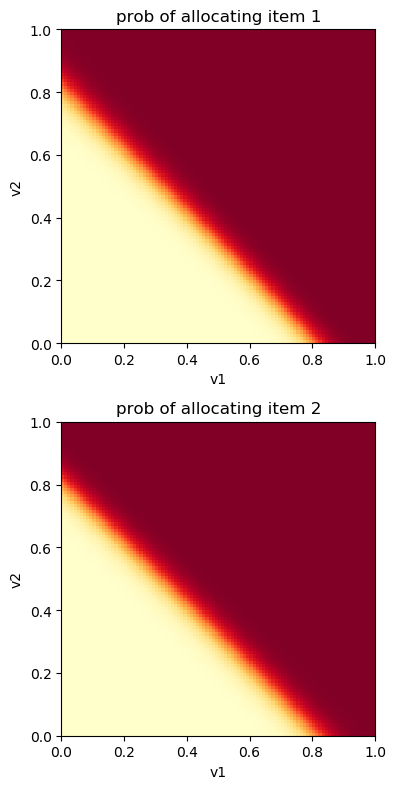

In [24]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
model.sinkhorn_rounds = 100
model.sinkhorn_epsilon = 5e-2
pu.plot_12_model(model.to(device='cpu'), 0.01, (0,1), (0,1))

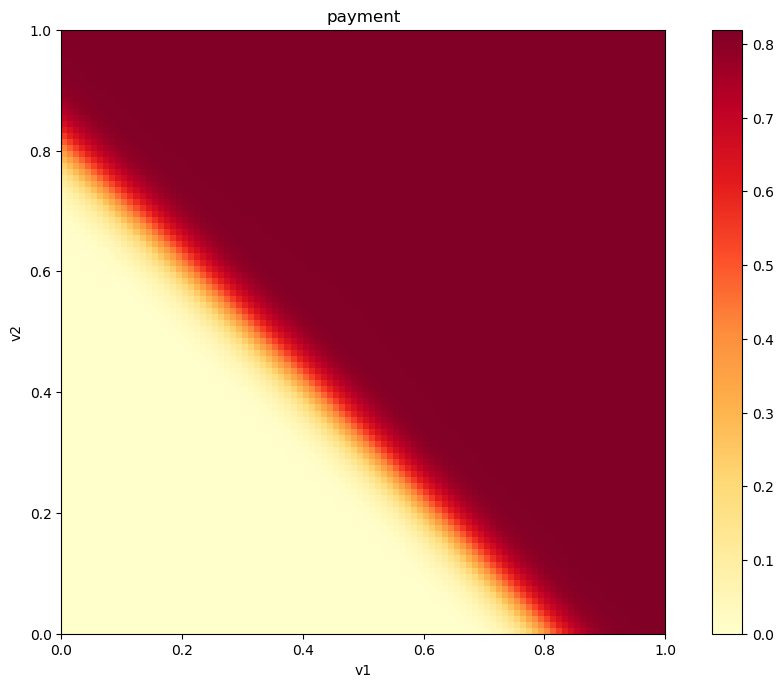

In [20]:
def plot_12_model_payments(model, grid_width=0.1, item1_range=(0, 1), item2_range=(0, 1), name="test"):
    item1_min, item1_max = item1_range
    item2_min, item2_max = item2_range
    xcoords = (item1_max - item1_min) * torch.arange(0, 1, grid_width).view(1, -1) + item1_min
    ycoords = (item2_max - item2_min) * torch.arange(0, 1, grid_width).view(-1, 1) + item2_min
    xlen = ycoords.shape[0]
    ylen = xcoords.shape[1]

    xcoords_tiled = xcoords.repeat(xlen, 1)
    ycoords_tiled = ycoords.repeat(1, ylen)

    combined = torch.stack((xcoords_tiled, ycoords_tiled), dim=2)

    output_allocs, output_payments = model(combined.view(-1, 1, 2))

    output_item1_payments = output_payments.view(xlen, ylen)
    f, (ax1) = plt.subplots(1, 1)
    im1 = ax1.imshow(output_item1_payments.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=[0,1,0,1])
    ax1.set_title('payment')
    ax1.set_xlabel('v1')
    ax1.set_ylabel('v2')
    f.colorbar(im1)
    f.show()
    
plot_12_model_payments(model.to(device='cpu'), 0.01, (0,1), (0,1))

In [9]:
hard_sample = torch.tensor([[[.75, .05]]])